# Simulation of HPL on Dahu

In [1]:
import io
import zipfile
import os
import pandas
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import yaml
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # removing annoying Pandas warning

def get_yaml(archive_name, yaml_name):
    archive = zipfile.ZipFile(archive_name)
    return yaml.load(io.BytesIO(archive.read(yaml_name)))

def get_platform(archive_name):
    info = get_yaml(archive_name, 'info.yaml')
    expfiles = info['expfile']
    platform = [f for f in expfiles if f.endswith('xml')]
    assert len(platform) == 1
    return platform[0]

def read_csv(archivename, filename):
    archive = zipfile.ZipFile(archivename)
    return pandas.read_csv(io.BytesIO(archive.read(filename)))

def read_result(name):
    return read_csv(name, 'result.csv')

def read_sim_result(name):
    archive = zipfile.ZipFile(name)
    result = pandas.read_csv(io.BytesIO(archive.read('results.csv')))
    result['platform'] = get_platform(name)
    info = get_yaml(name, 'info.yaml')
    installfile = info['installfile']
    result['model'] = installfile[8:10]  # filename of the form 'install_A1.yaml', so we get the 'A1'
    install_options = get_yaml(name, installfile)
    result['stochastic_cpu'] = install_options['stochastic_cpu']
    result['polynomial_dgemm'] = install_options['polynomial_dgemm']
    result['stochastic_network'] = install_options['stochastic_network']
    memory = read_csv(name, 'memory_0.csv')
    result['memory_consumption'] = memory['MemAvailable'].max() - memory['MemAvailable'].min()
    result['filename'] = name
    return result

simulation_dir = 'paper_sc19/scalability/1/'
simulation_files = [simulation_dir + f for f in os.listdir(simulation_dir)]

df = pandas.concat([read_sim_result(f) for f in simulation_files])
df.head()

,application_time,bcast,block_size,cpu_utilization,depth,dgemm_coefficient,dgemm_intercept,dtrsm_coefficient,dtrsm_intercept,filename,...,process_per_node,rfact,simulation_time,stochastic_cpu,stochastic_network,swap,sys_time,thread_per_process,time,usr_time
0,730.844,2,128,0.99,1,42.0,42.0,42.0,42.0,paper_sc19/scalability/1/grenoble_2019-03-27_1...,...,32,2,7533.87,True,True,0,2398.92,1,6102.53,5121.32
0,1640.190,2,128,0.99,1,42.0,42.0,42.0,42.0,paper_sc19/scalability/1/grenoble_2019-03-27_1...,...,32,2,17354.10,True,True,0,5851.24,1,3165.46,11463.60
0,3622.640,2,128,0.99,1,42.0,42.0,42.0,42.0,paper_sc19/scalability/1/grenoble_2019-03-27_1...,...,32,2,40447.70,True,True,0,9860.60,1,1725.13,30496.72
0,1898.660,2,128,0.99,1,42.0,42.0,42.0,42.0,paper_sc19/scalability/1/grenoble_2019-03-27_1...,...,32,2,23902.50,True,True,0,9209.88,1,48040.48,14637.22


### Checking the parameters

In [2]:
df[['dgemm_coefficient', 'dgemm_intercept', 'dtrsm_coefficient', 'dtrsm_intercept']].drop_duplicates()

,dgemm_coefficient,dgemm_intercept,dtrsm_coefficient,dtrsm_intercept
0,42.0,42.0,42.0,42.0


In [3]:
name_exceptions = {'application_time', 'simulation_time', 'usr_time', 'sys_time', 'time', 'gflops', 'residual', 'cpu_utilization',
                   'dgemm_coefficient', 'dgemm_intercept', 'dtrsm_coefficient', 'dtrsm_intercept',
                   'stochastic_cpu', 'polynomial_dgemm', 'stochastic_network', 'platform', 'model',
                   'memory_consumption', 'filename',
                   'major_page_fault', 'minor_page_fault', 'mode'}
colnames = set(df) - name_exceptions
df[list(colnames)].drop_duplicates()

,swap,thread_per_process,proc_p,rfact,bcast,block_size,depth,matrix_size,mem_align,process_per_node,proc_q,pfact
0,0,1,16,2,2,128,1,500000,8,32,32,1
0,0,1,32,2,2,128,1,500000,8,32,32,1
0,0,1,64,2,2,128,1,500000,8,32,32,1
0,0,1,16,2,2,128,1,1000000,8,32,32,1


In [4]:
from IPython.display import display, Markdown

platforms = [(get_platform(f), zipfile.ZipFile(f).read(get_platform(f)).decode('ascii')) for f in simulation_files] # I changed the platform in this new simulation, calls to SMPI_Wtime now do not take time
# platforms = [zipfile.ZipFile(f).read('dahu.xml').decode('ascii') for f in (simulation_files + simulation_files_old)]
platforms = list(set(platforms))
assert(len(platforms)) == 1
for name, plat in platforms:
    display(Markdown('### %s' % name))
    display(Markdown('```xml\n%s\n```' % plat))

### dahu.xml

```xml
<?xml version="1.0"?>
<!DOCTYPE platform SYSTEM "http://simgrid.gforge.inria.fr/simgrid/simgrid.dtd">

<platform version="4.1">
    <config id="General">
        <prop id="smpi/os" value="0:2.965491847282898e-07:9.63619592297199e-11;8133:4.117386759387727e-06:9.998650637323814e-11;15831:3.901910334928982e-06:1.1003492469181915e-10;33956:8.556208528368661e-06:1.2636592924112397e-10;64000:0.0:0.0"/>
        <prop id="smpi/or" value="0:1.3754300044375236e-06:8.456019002037162e-11;8133:1.0616877366305338e-06:1.0399801951417905e-10;15831:1.1989168715510673e-06:9.880880432093221e-11;33956:1.3028804423006338e-06:1.0742263180618875e-10;64000:0.0:0.0"/>
        <prop id="smpi/ois" value="0:6.931229521083401e-07:7.051204536228214e-11;8133:3.601990790153244e-07:1.2449128895712037e-10;15831:2.97701688103096e-06:4.1302612649640425e-11;33956:3.133466154066955e-06:3.293458765281899e-11;64000:6.939993663604069e-07:0.0"/>
        <prop id="smpi/bw-factor" value="0:0.4955575510466301;8133:5.649491428460505;15831:5.716405752533658;33956:12.659099698925065;64000:0.9867951082730274"/>
        <prop id="smpi/lat-factor" value="0:1.2162964660682605;8133:19.230103984475342;15831:18.285606440676755;33956:51.6103738900493;64000:129.24904864615127"/>
        <prop id="smpi/async-small-thresh" value="64000"/>
        <prop id="smpi/send-is-detached-thresh" value="64000"/>
        <prop id="smpi/iprobe" value="2.115437983643232e-07"/>
        <prop id="smpi/test" value="8.090518732515405e-07"/>
        <prop id="smpi/host-speed" value="1"/>
    </config>

    <AS id="AS0" routing="Full">
        <cluster id="cluster" prefix="dahu-" suffix=".grid5000.fr" radical="0-127" speed="1" core="32" bw="12.5GBps" lat="0.05us" loopback_bw="18.348422228142745GBps" loopback_lat="0.0us"/>
    </AS>
</platform>

```

### Checking the patch in the new simulation

In [5]:
patches = {}
for archive in simulation_files:
    installfile = get_yaml(archive, 'info.yaml')['installfile']
    install_options = get_yaml(archive, installfile)
    stochastic_cpu = install_options['stochastic_cpu']
    polynomial_dgemm = install_options['polynomial_dgemm']
    repos = get_yaml(archive, 'info.yaml')['git_repositories']
    hpl = [repo for repo in repos if repo['path'] == 'hpl-2.2']
    assert len(hpl) == 1
    try:
        patches[(stochastic_cpu, polynomial_dgemm)].add(hpl[0]['patch'])
    except KeyError:
        patches[(stochastic_cpu, polynomial_dgemm)] = {(hpl[0]['patch'])}
for (stochastic_cpu, polynomial_dgemm), patch in patches.items():
    assert len(patch) == 1
    display(Markdown('### stochastic_cpu=%s  |  polynomial_dgemm=%s' % (stochastic_cpu, polynomial_dgemm)))
    display(Markdown('```diff\n%s\n```' % patch.pop()))

### stochastic_cpu=True  |  polynomial_dgemm=True

```diff

diff --git a/Make.SMPI b/Make.SMPI
index c34be62..a610089 100644
--- a/Make.SMPI
+++ b/Make.SMPI
@@ -68,7 +68,7 @@ ARCH         = $(arch)
 # - HPL Directory Structure / HPL library ------------------------------
 # ----------------------------------------------------------------------
 #
-TOPdir       = /home/tom/Documents/Fac/2017_Stage_LIG/hpl-2.2
+TOPdir=/tmp/hpl-2.2
 INCdir       = $(TOPdir)/include
 BINdir       = $(TOPdir)/bin/$(ARCH)
 LIBdir       = $(TOPdir)/lib/$(ARCH)
@@ -93,9 +93,9 @@ MPlib        =
 # header files,  LAlib  is defined  to be the name of  the library to be
 # used. The variable LAdir is only used for defining LAinc and LAlib.
 #
-LAdir        = /usr/lib
+LAdir        = /tmp/lib
 LAinc        =
-LAlib        = -lblas
+LAlib        = /tmp/lib/libopenblas.so
 #
 # ----------------------------------------------------------------------
 # - F77 / C interface --------------------------------------------------
 
```

### Efficiency of the simulation

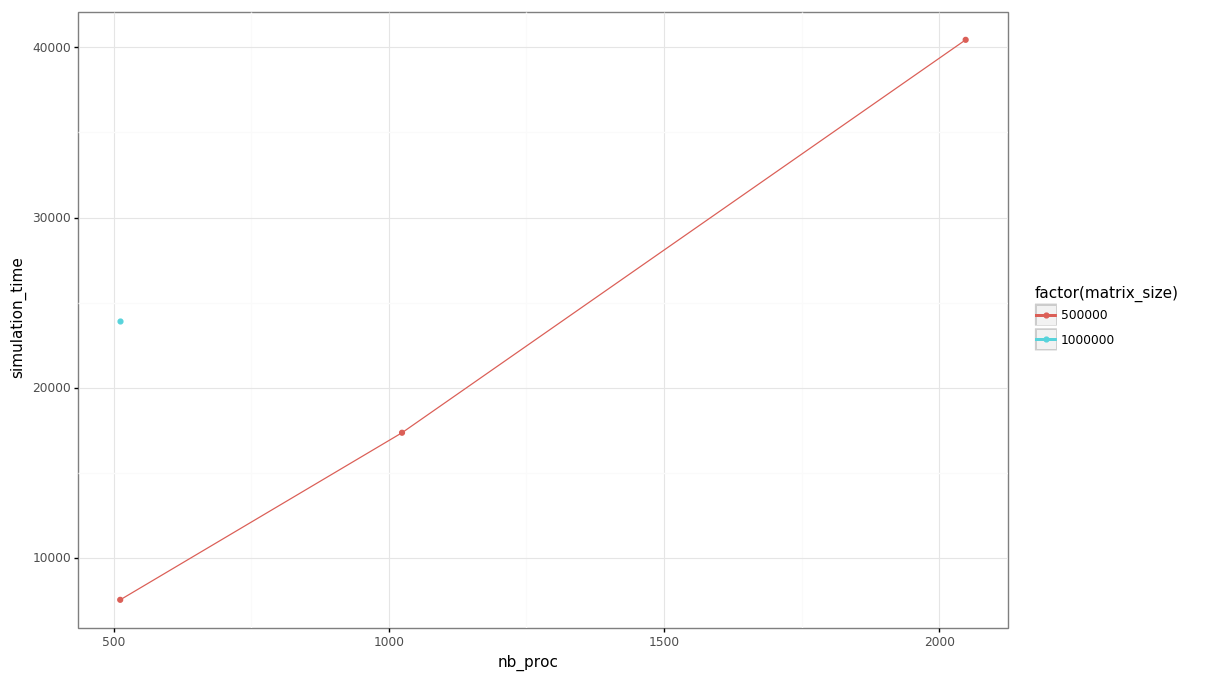

<ggplot: (8748932738326)>


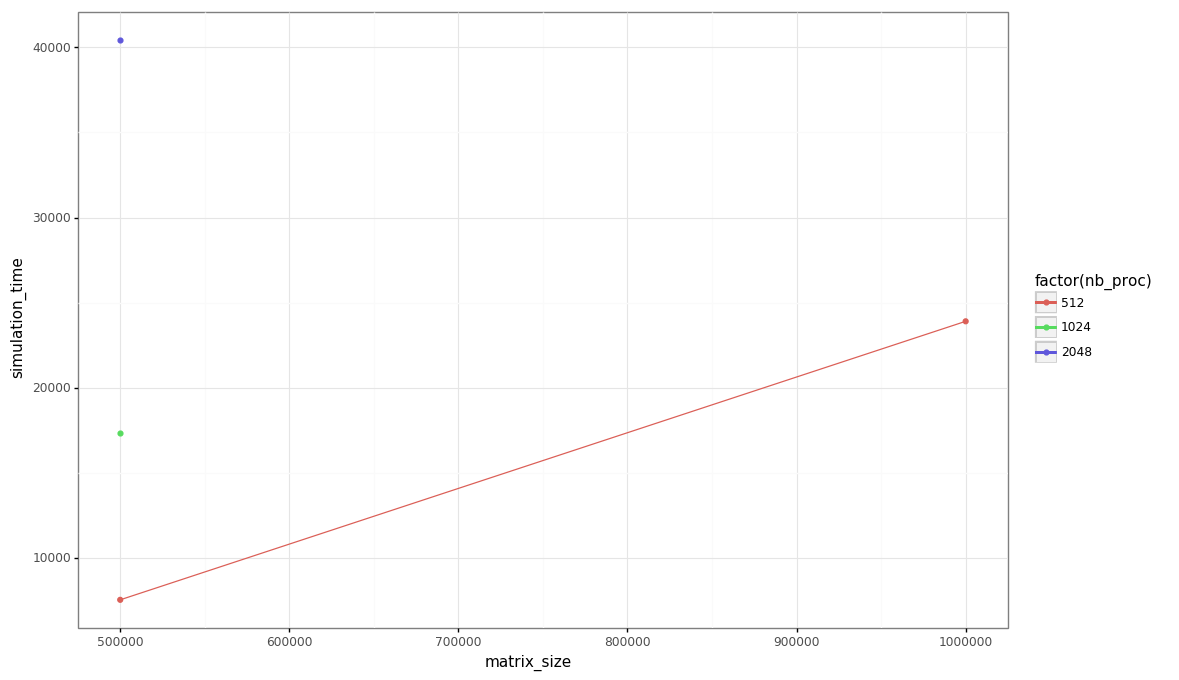

<ggplot: (-9223363287922044237)>


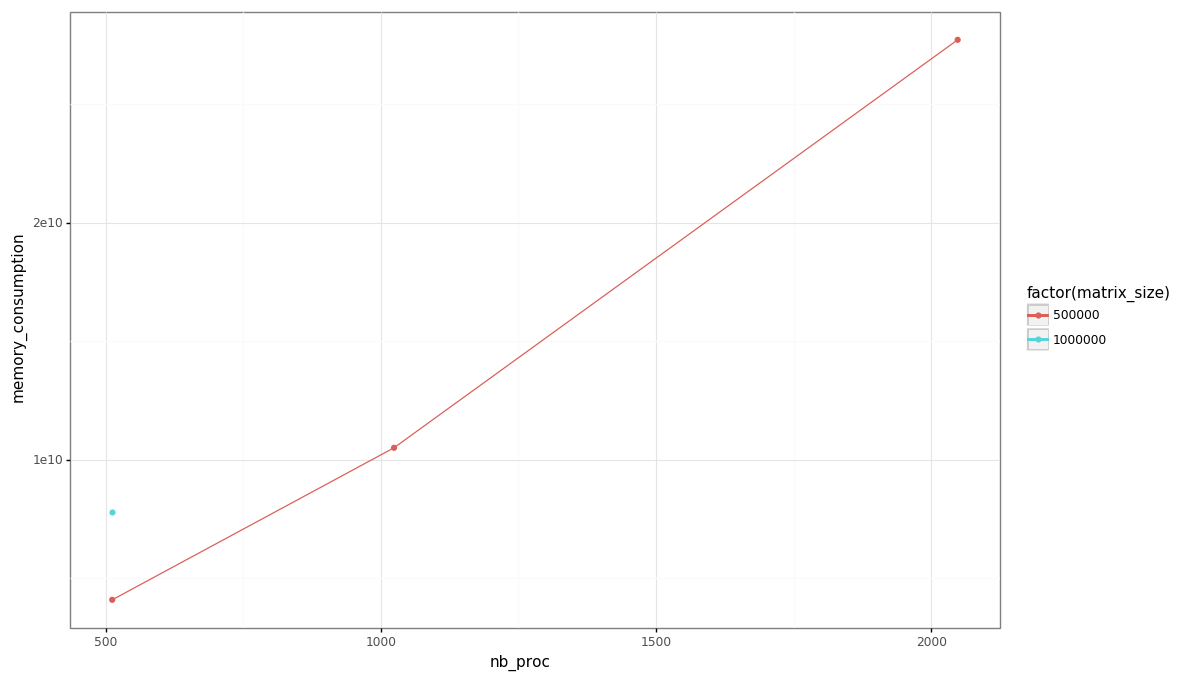

<ggplot: (-9223363287922201596)>


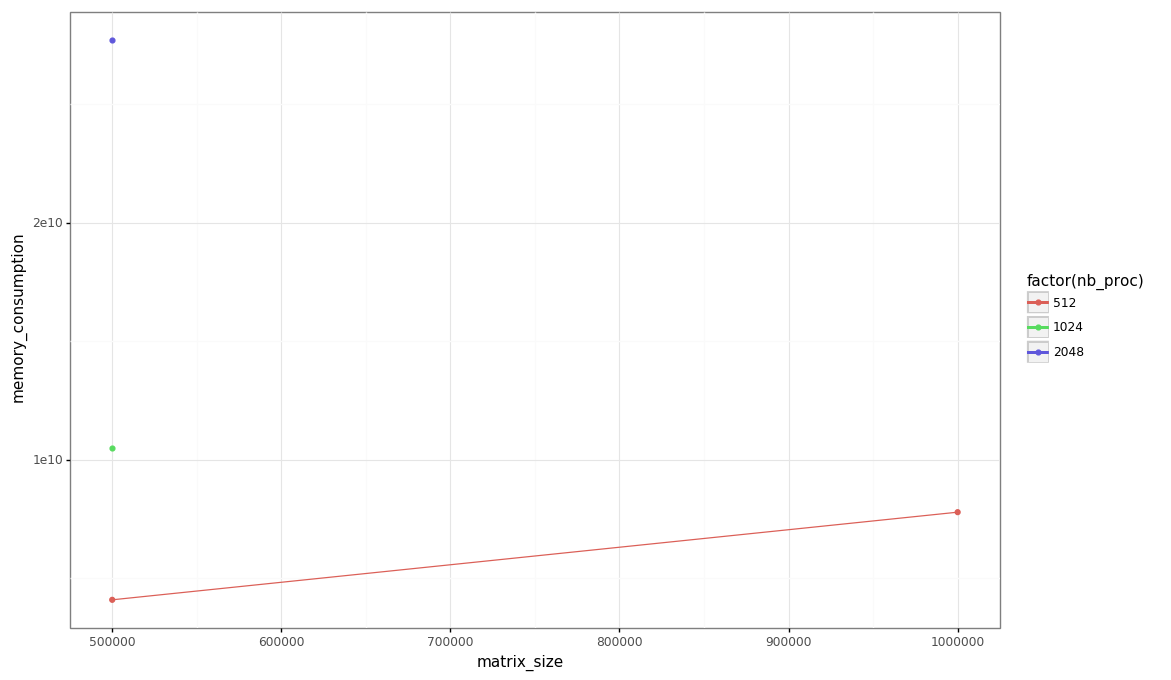

<ggplot: (-9223363287922353678)>


In [6]:
df['nb_proc'] = df['proc_p'] * df['proc_q']
df['simgrid_time'] = df['simulation_time'] - df['application_time']
def plot(df, x, y, color):
    plot = ggplot(df, aes(x=x, y=y, color='factor(%s)' % color)) + geom_point() + geom_line() + theme_bw()
    return plot

for y in ['simulation_time', 'memory_consumption']:
    print(plot(df, 'nb_proc', y, 'matrix_size'))
    print(plot(df, 'matrix_size', y, 'nb_proc'))

### Memory profile

In [7]:
filename = list(df[df['memory_consumption'] == df['memory_consumption'].max()].filename)[0]
filename

'paper_sc19/scalability/1/grenoble_2019-03-27_1856747.zip'

In [8]:
memory = read_csv(filename, 'memory_0.csv')
memory['timestamp'] = pandas.to_datetime(memory['timestamp'])
memory['timestamp'] -= memory['timestamp'].min()
memory['memory_consumption'] = memory['MemAvailable'].max()-memory['MemAvailable']
memory.head()

,timestamp,Inactive(file),SwapCached,Dirty,ShmemPmdMapped,HugePages_Surp,SwapTotal,HugePages_Free,Buffers,PageTables,...,AnonPages,Inactive(anon),Hugepagesize,Committed_AS,Unevictable,ShmemHugePages,Active(file),DirectMap4k,DirectMap1G,memory_consumption
0,00:00:00,1265488000,0,42132000,0,0,3905532000,1,69796000,2120000,...,25552000,9716000,2048000,218448000,0,0,595700000,331584000,191889408000,19292000
1,00:00:01.002255,1460596000,0,237772000,0,0,3905532000,1,69844000,13848000,...,53144000,9716000,2048000,19460272000,0,0,595792000,331584000,191889408000,59068000
2,00:00:02.003489,2980624000,0,1751480000,0,0,3905532000,1,70228000,25444000,...,80060000,9716000,2048000,19472280000,0,0,595808000,331584000,191889408000,121892000
3,00:00:03.004667,3353356000,0,2123916000,0,0,3905532000,1,70316000,29276000,...,90440000,9716000,2048000,19472280000,0,0,596116000,331584000,191889408000,141380000
4,00:00:04.005818,3353356000,0,2123916000,0,0,3905532000,1,70316000,29480000,...,416792000,9716000,2048000,19797868000,0,0,596116000,331584000,191889408000,467996000


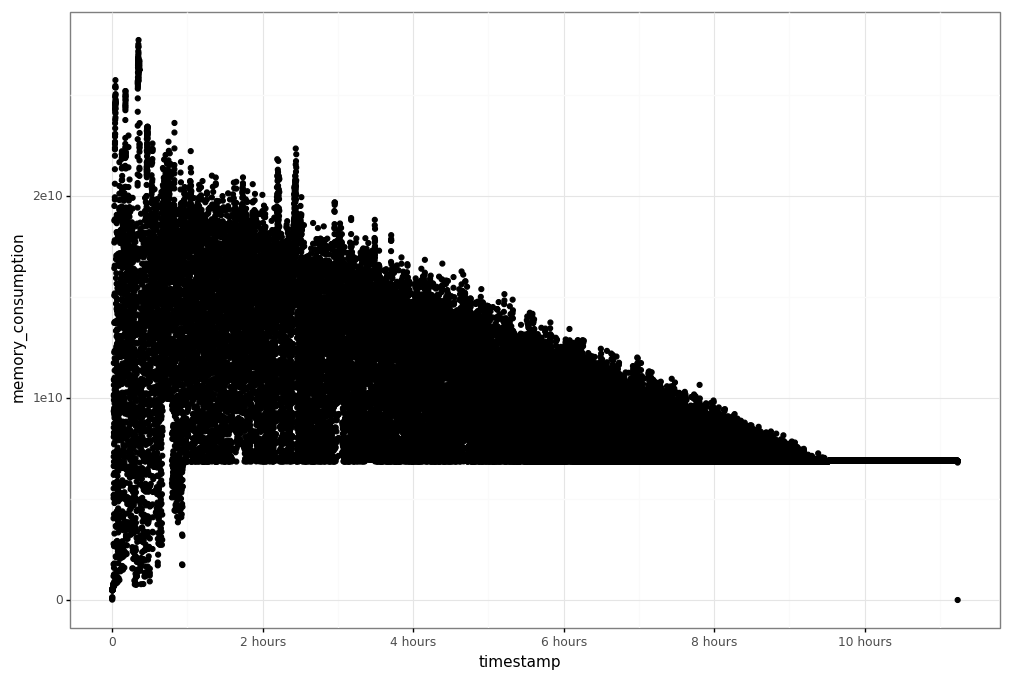

<ggplot: (-9223363287922067161)>

In [9]:
ggplot(memory, aes(x='timestamp', y='memory_consumption')) + geom_point() + theme_bw()

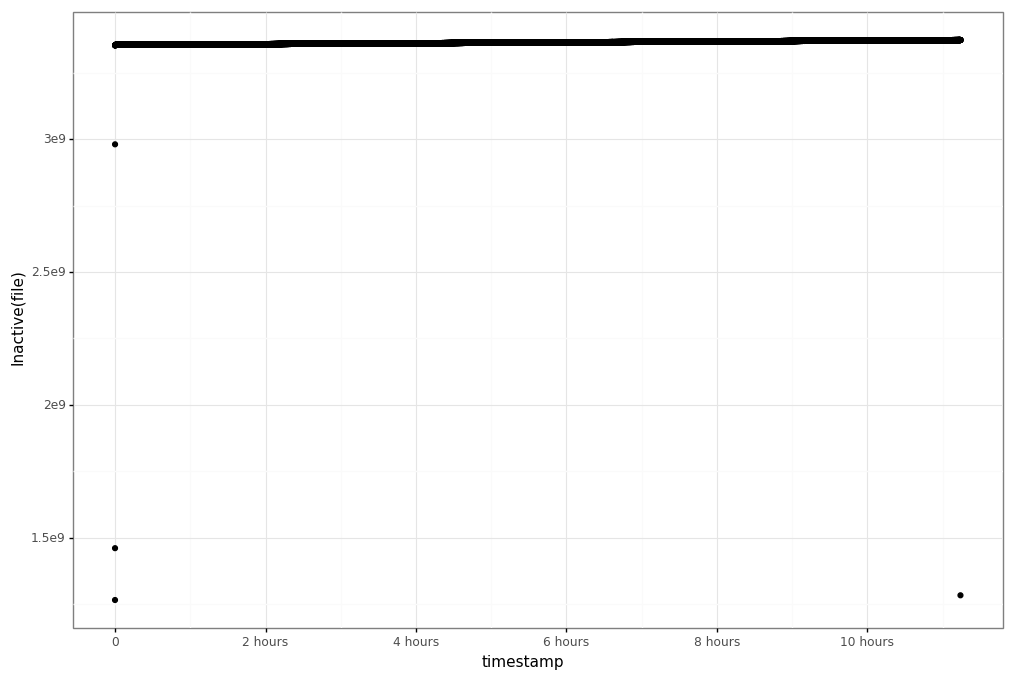

<ggplot: (8748932422078)>


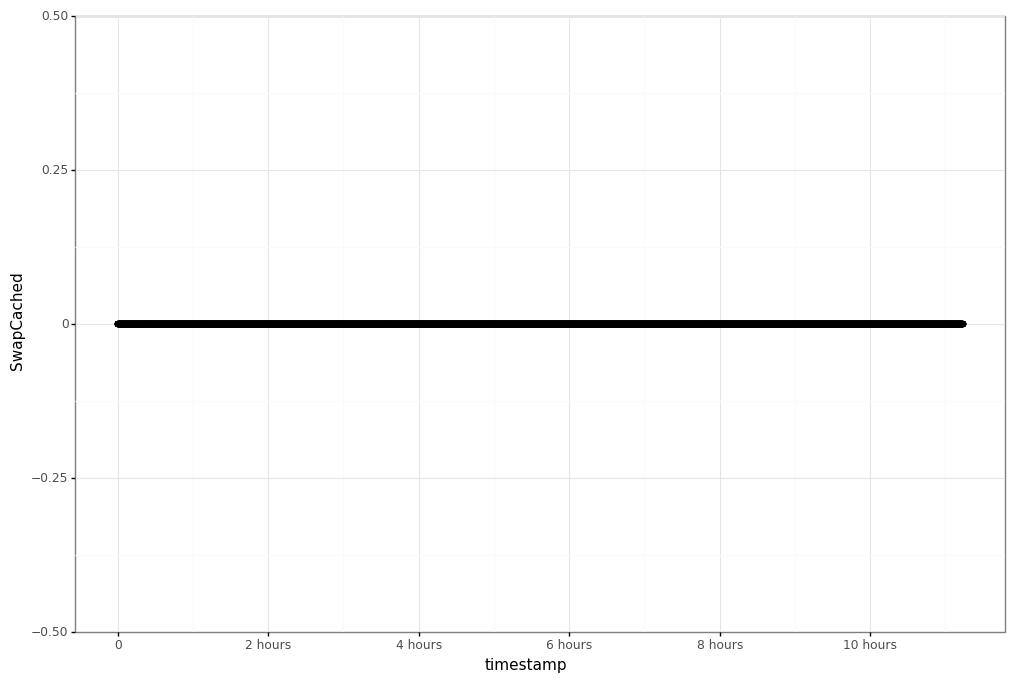

<ggplot: (8748932690671)>


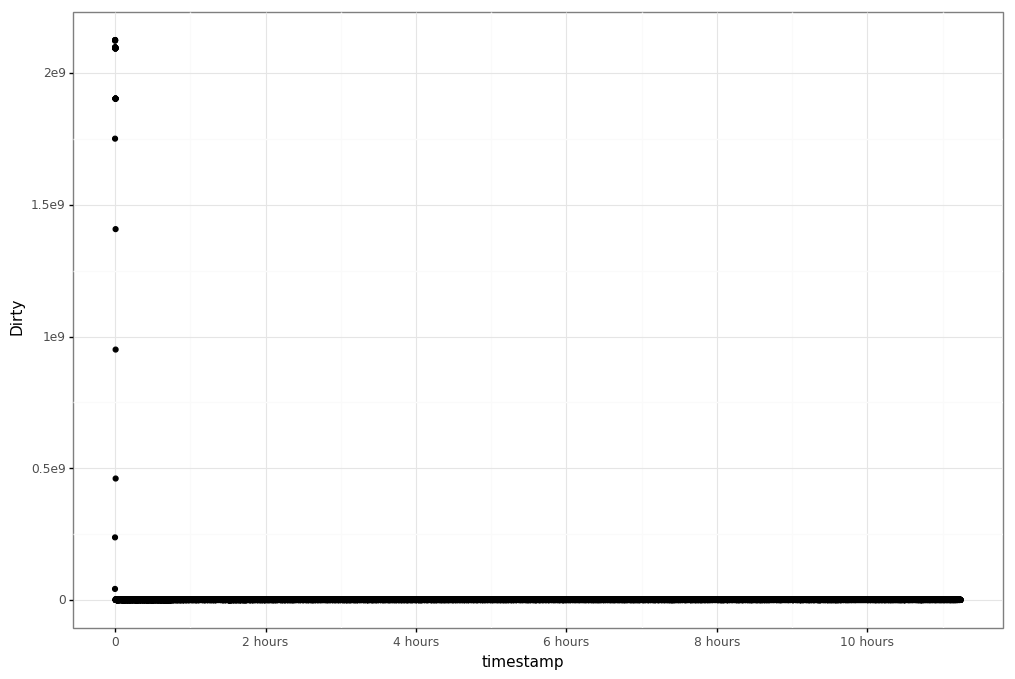

<ggplot: (-9223363287922074592)>


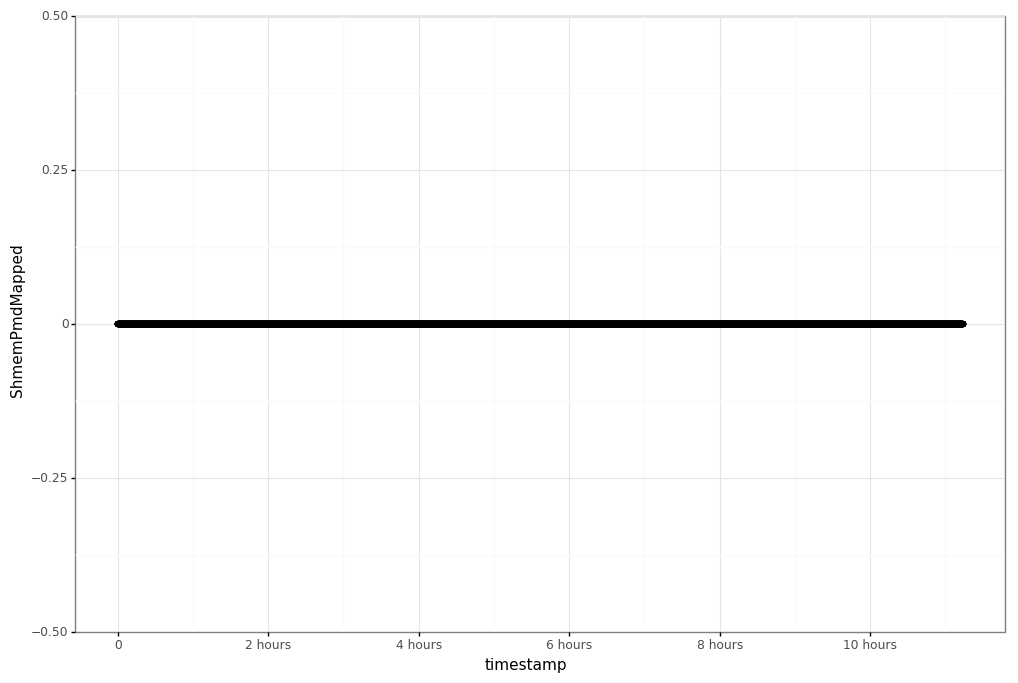

<ggplot: (8748932697243)>


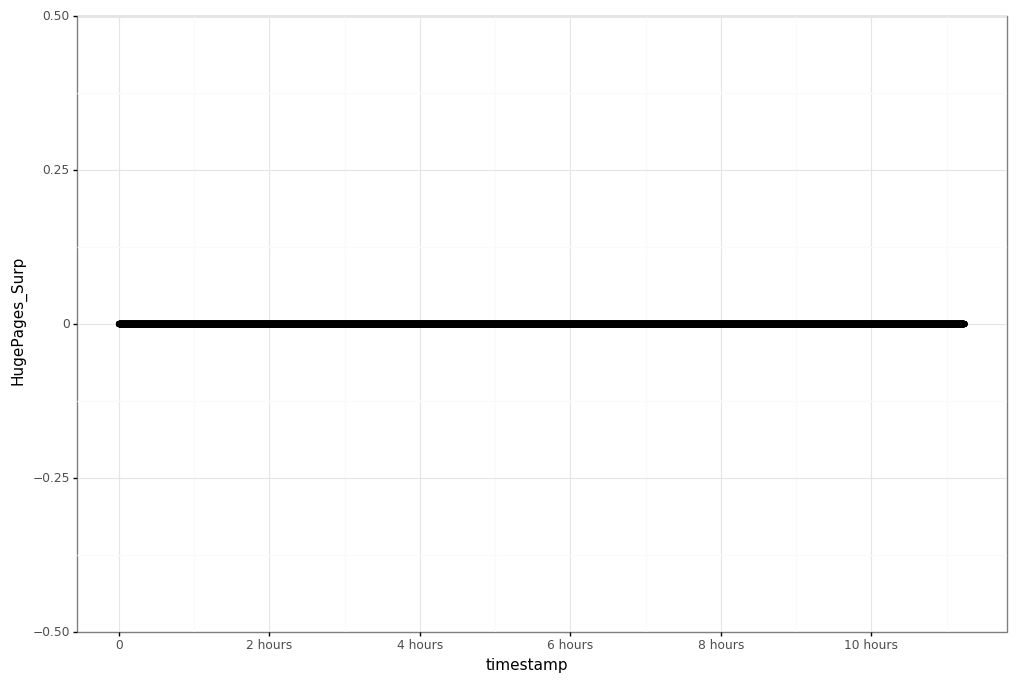

<ggplot: (8748932674017)>


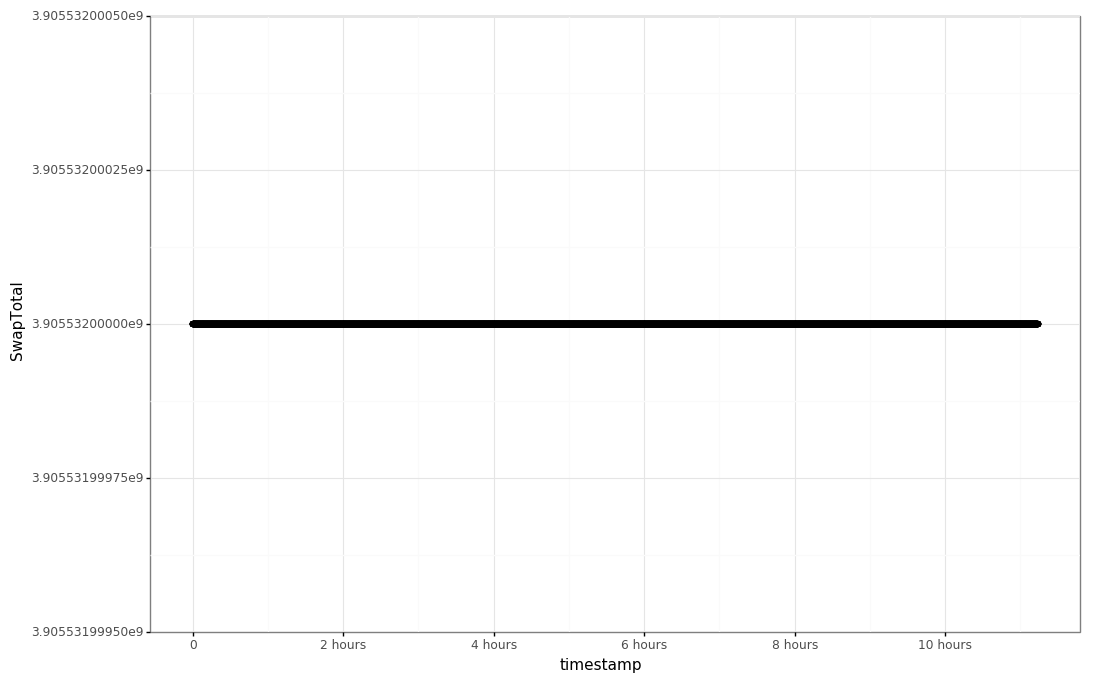

<ggplot: (-9223363287958446136)>


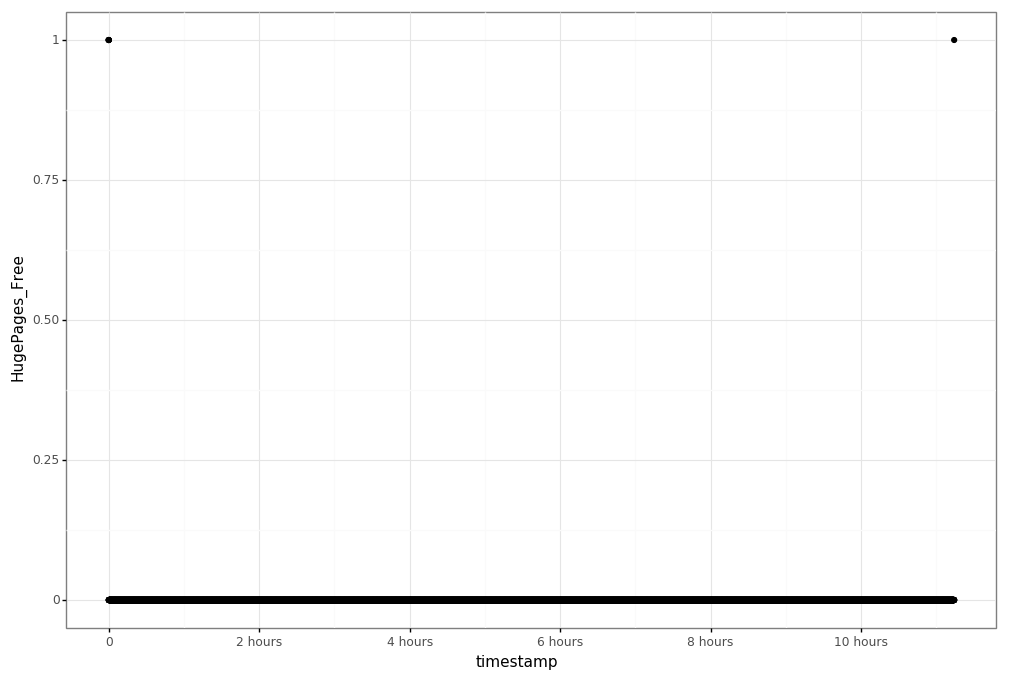

<ggplot: (8748932690454)>


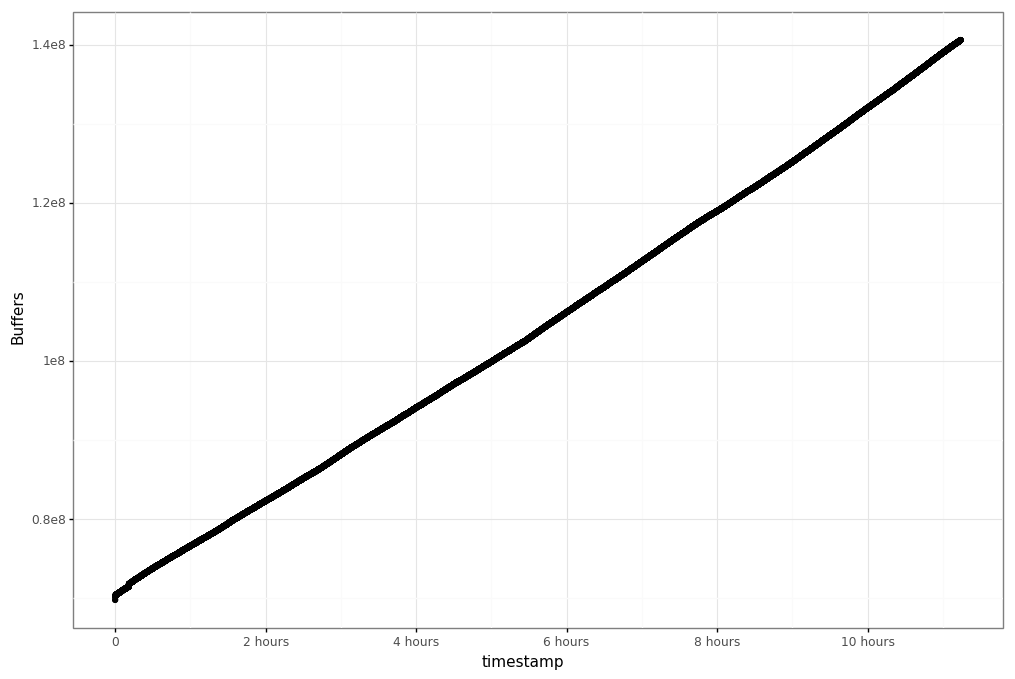

<ggplot: (8748932635028)>


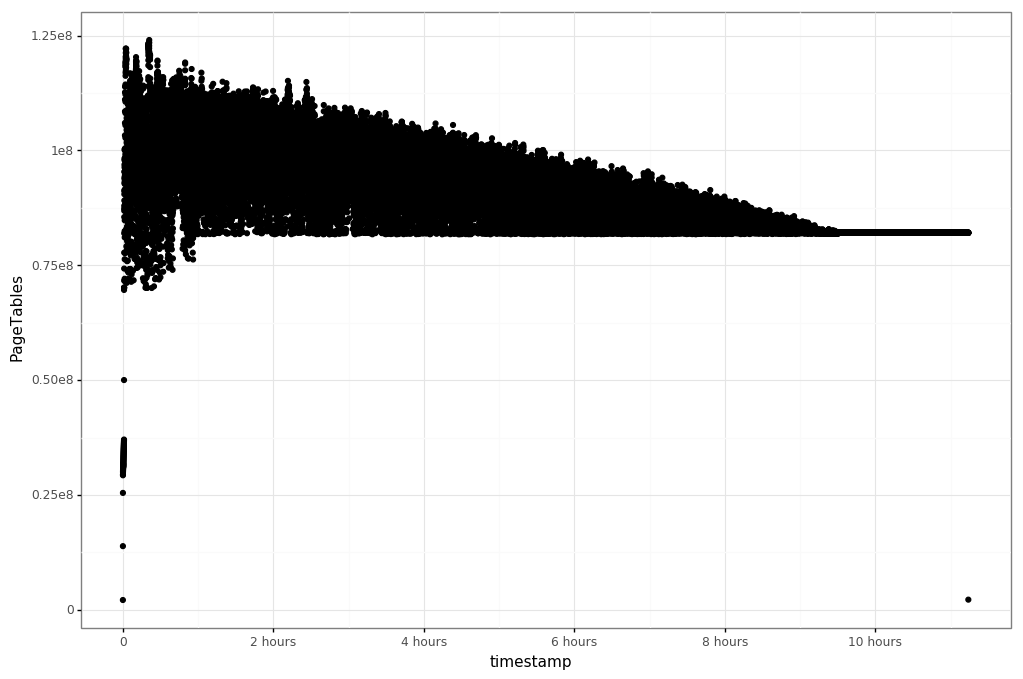

<ggplot: (8748896326920)>


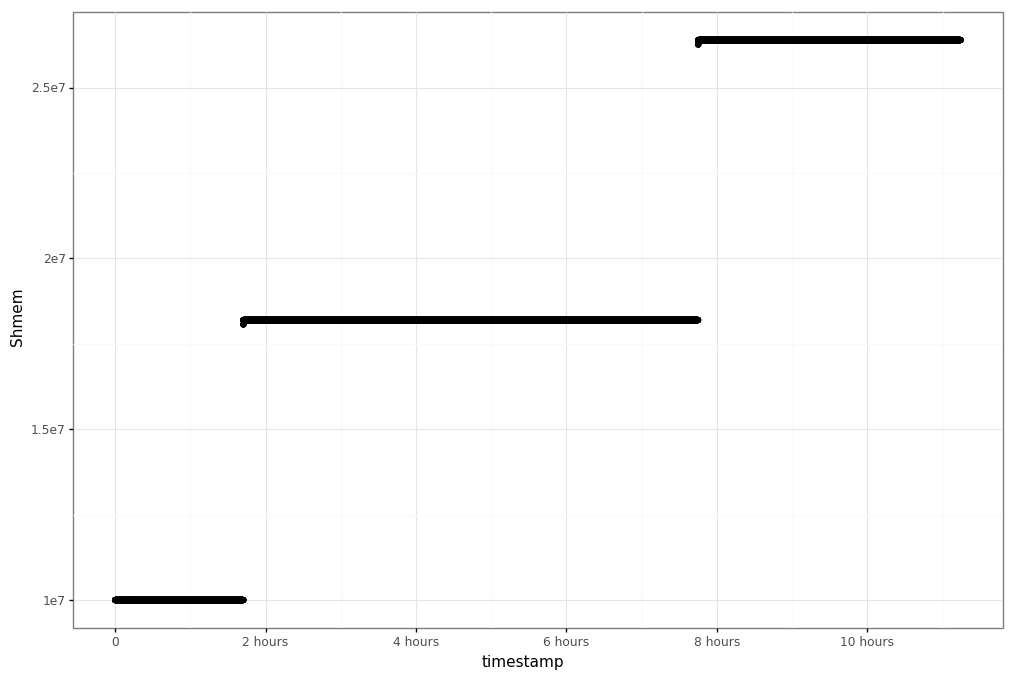

<ggplot: (8748896334049)>


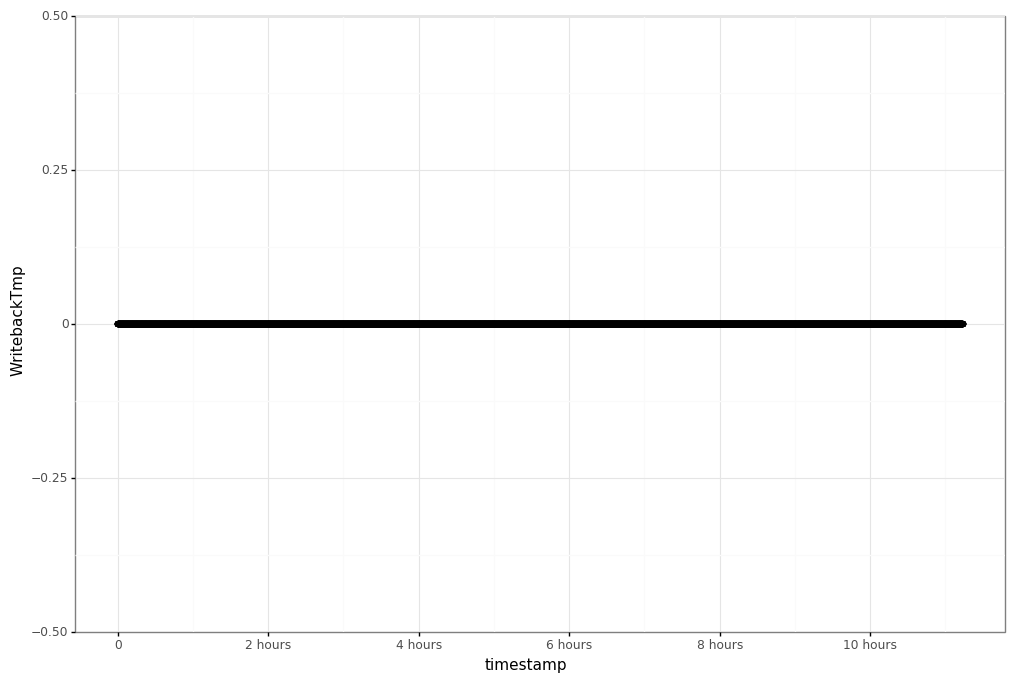

<ggplot: (-9223363287922351963)>


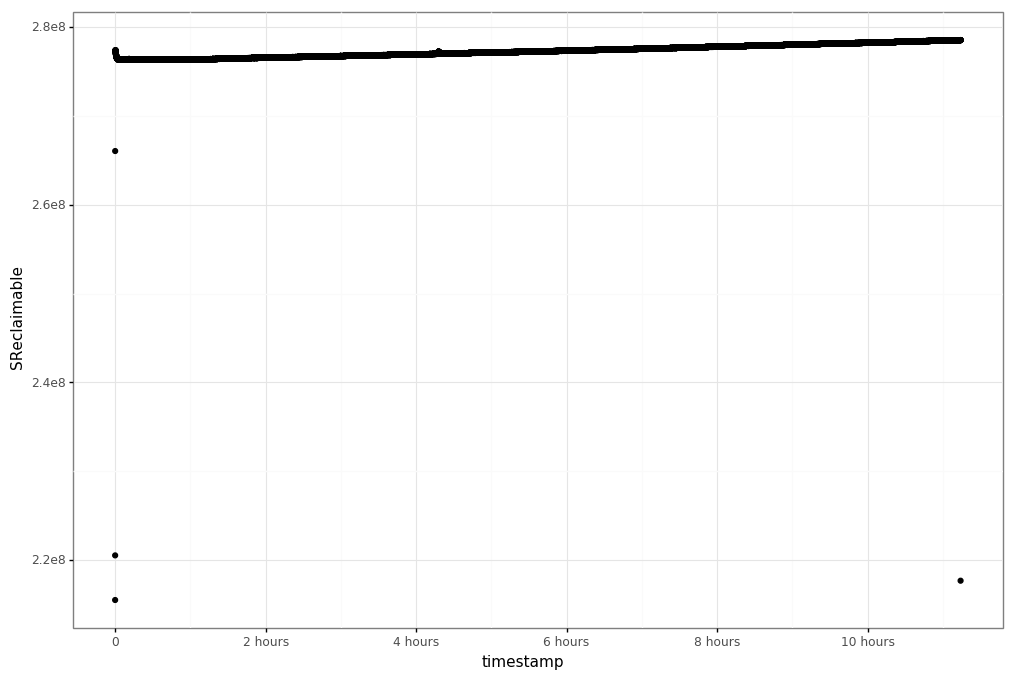

<ggplot: (8748932677587)>


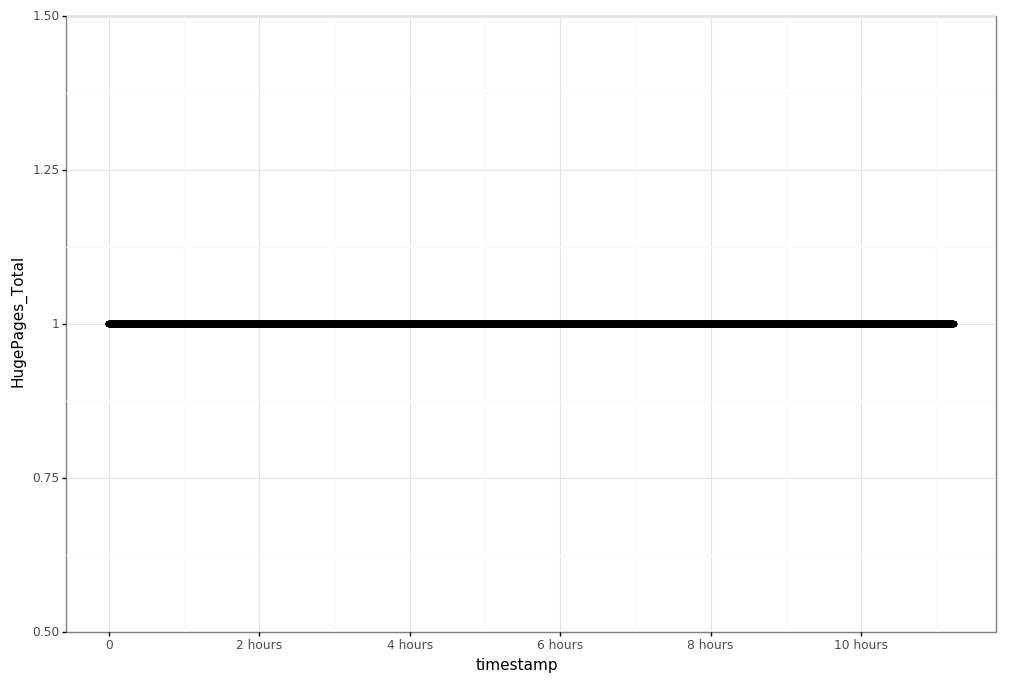

<ggplot: (8748932713806)>


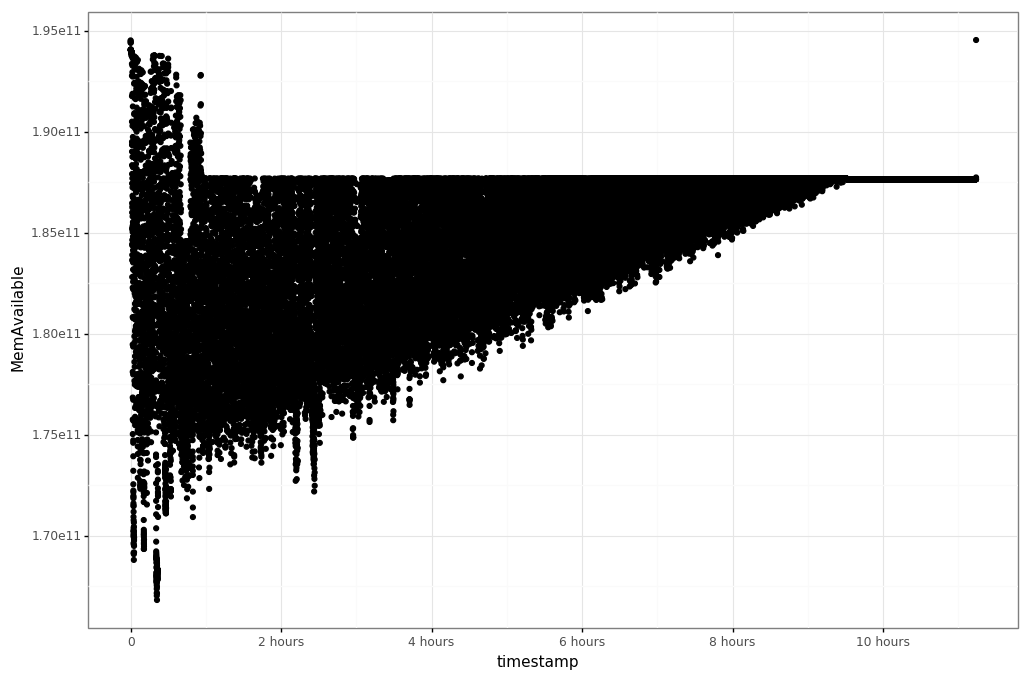

<ggplot: (8748932612714)>


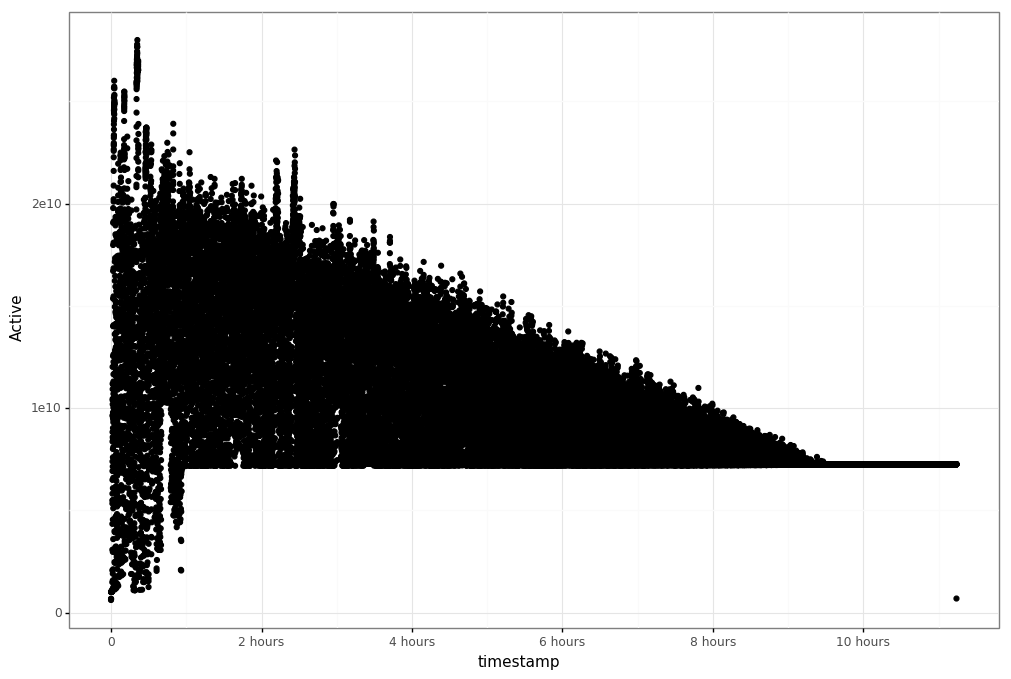

<ggplot: (8748932423688)>


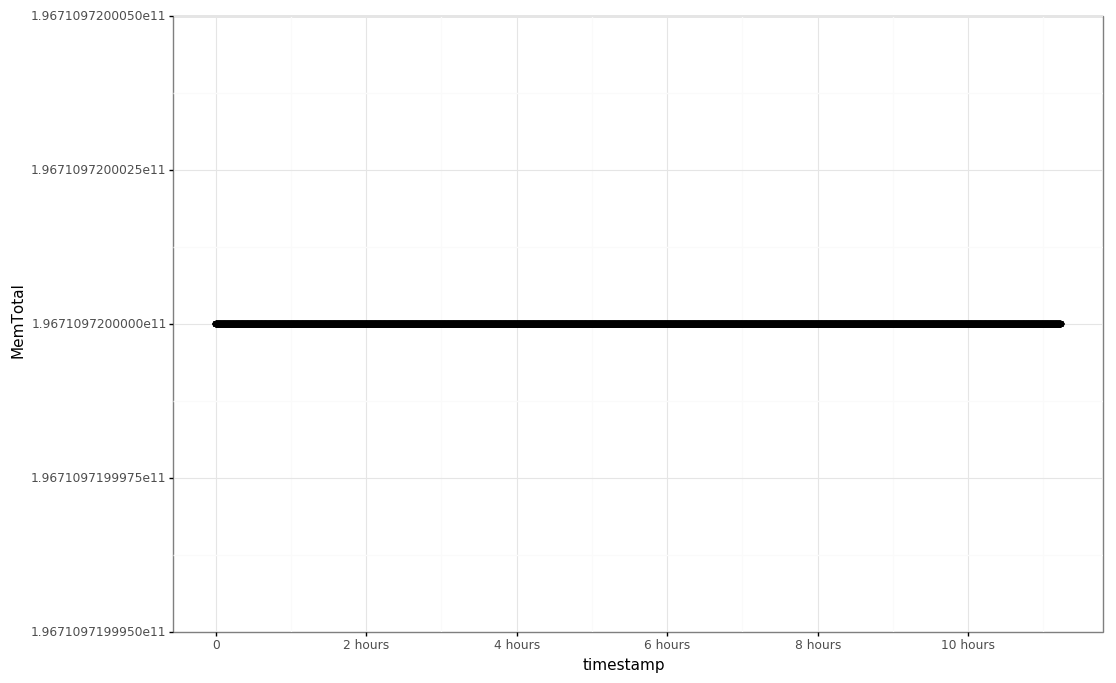

<ggplot: (8748932565817)>


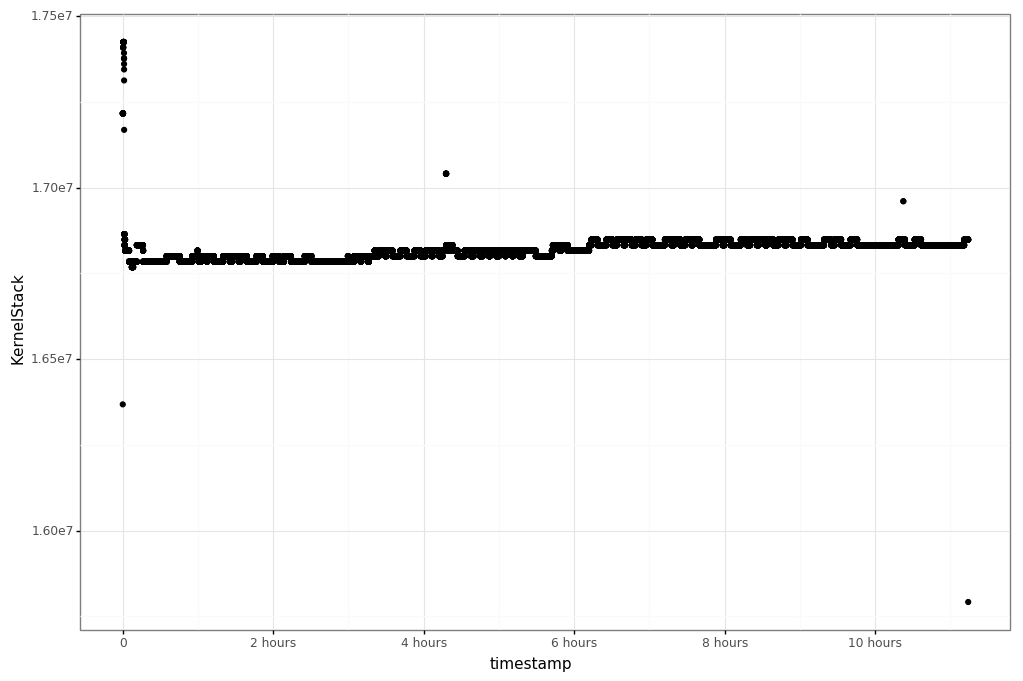

<ggplot: (8748932613082)>


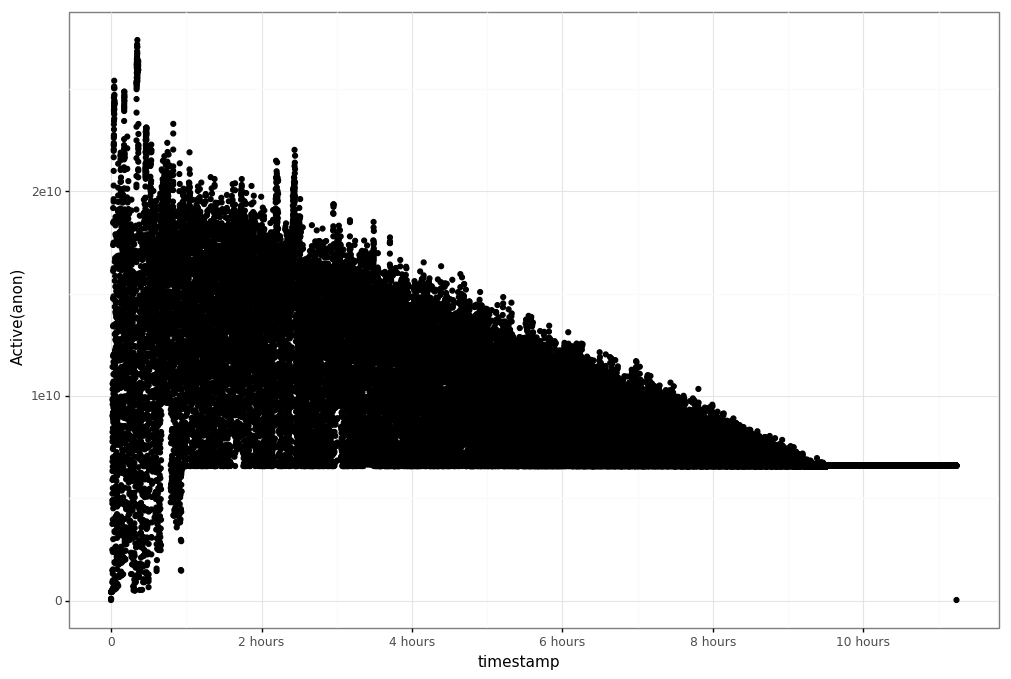

<ggplot: (8748932692849)>


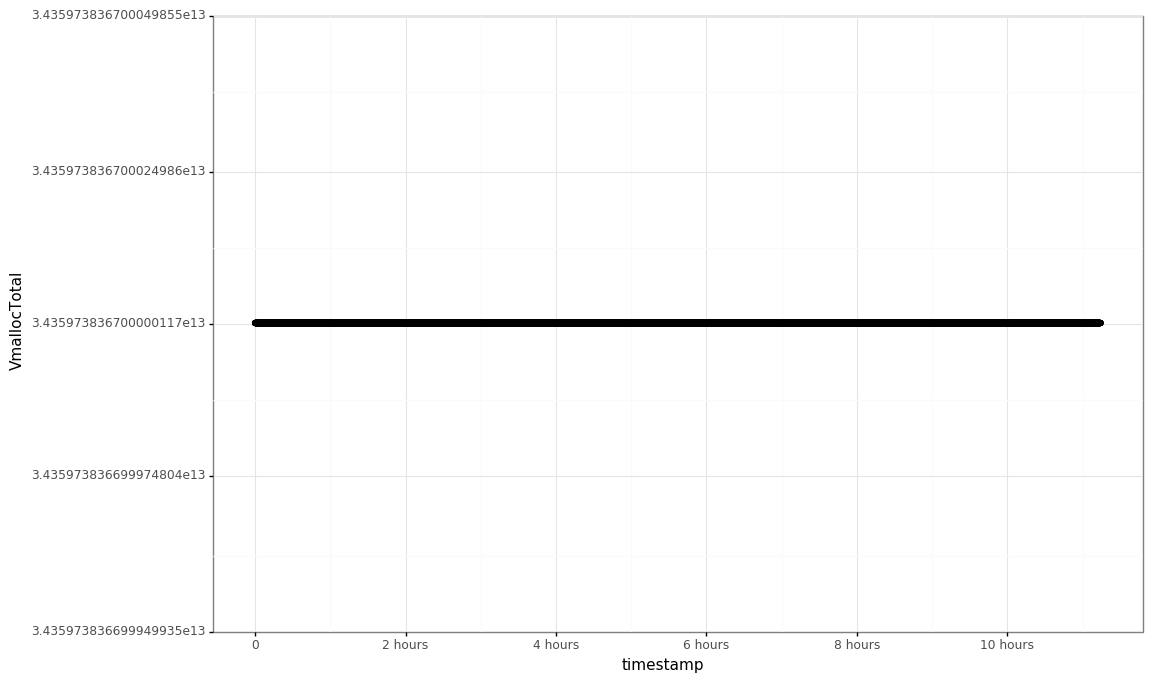

<ggplot: (-9223363287922108728)>


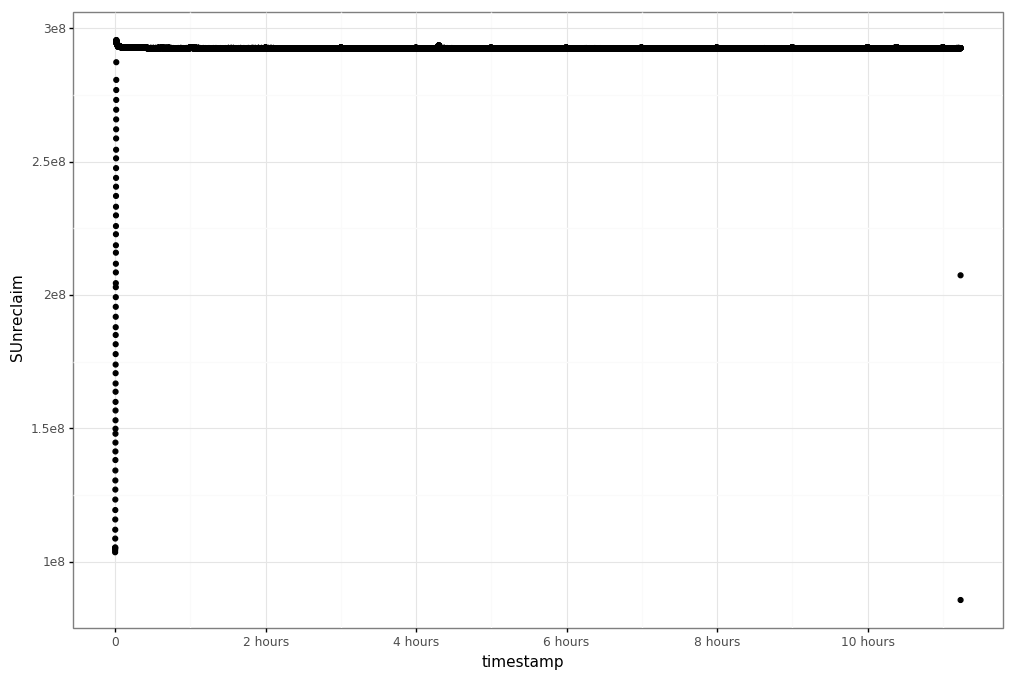

<ggplot: (-9223363287922066993)>


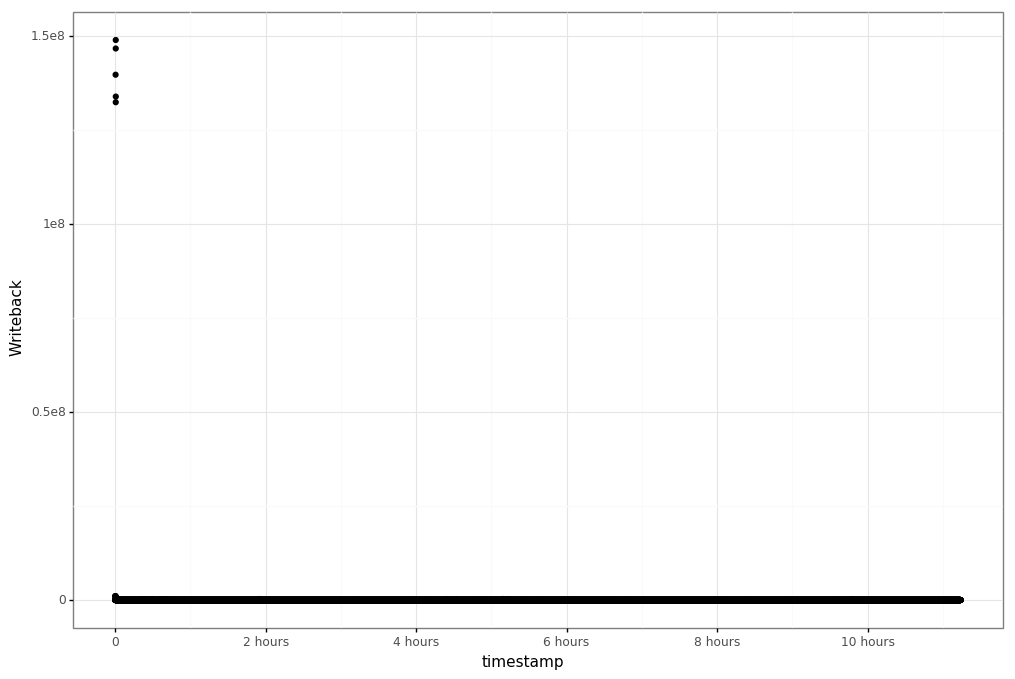

<ggplot: (-9223363287922082935)>


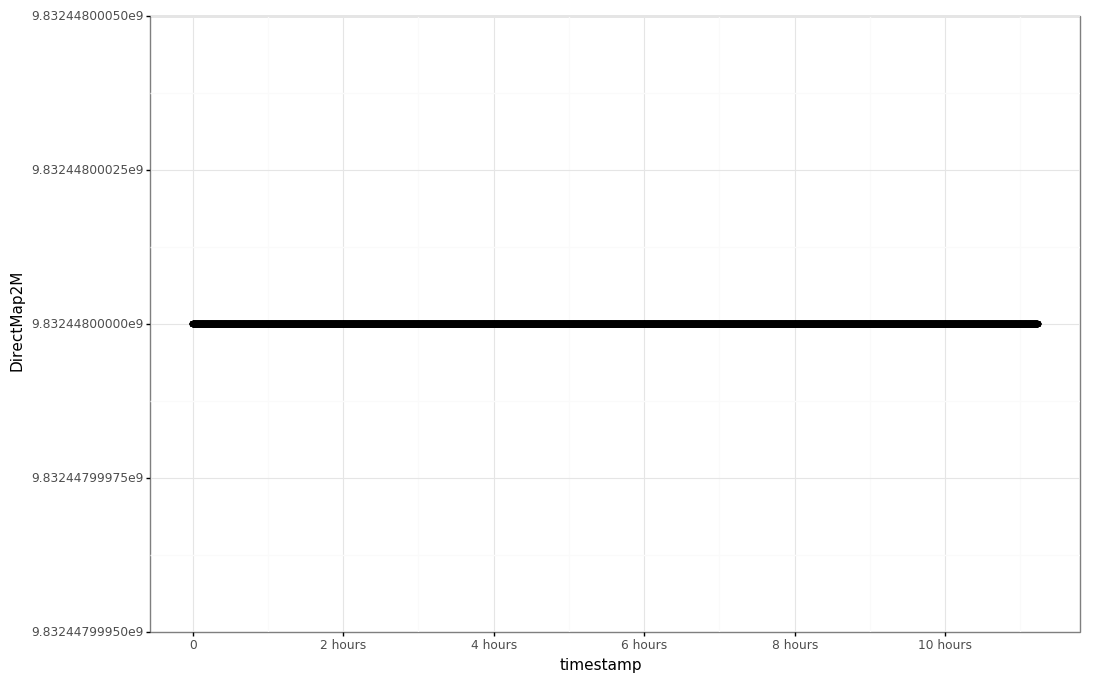

<ggplot: (8748932436572)>


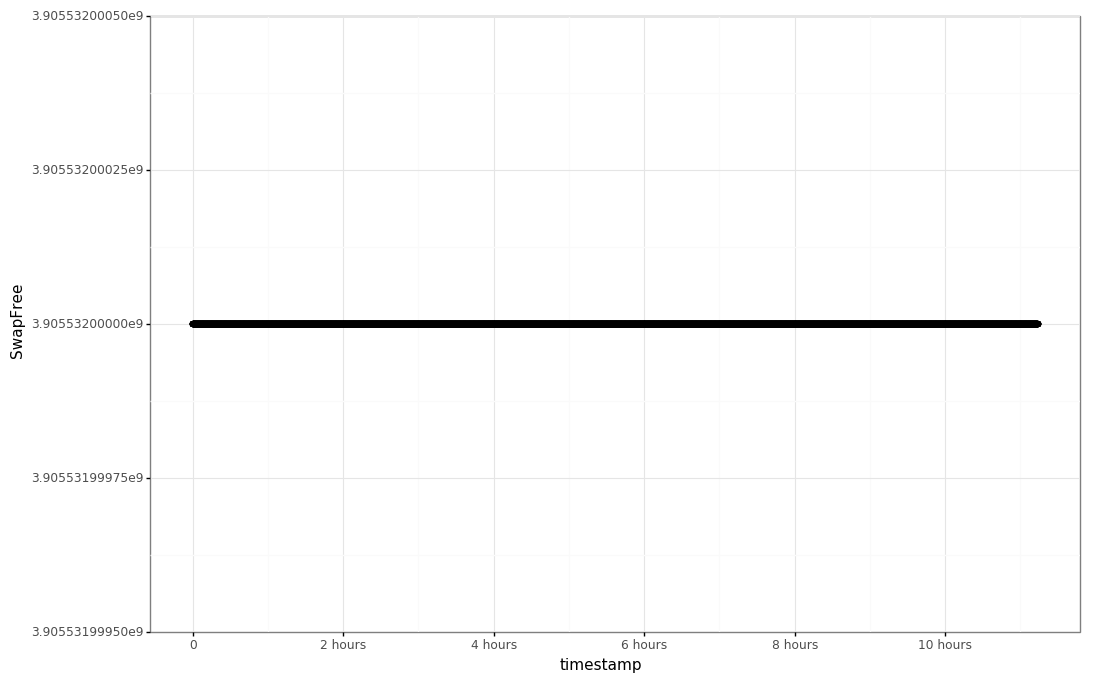

<ggplot: (8748932612798)>


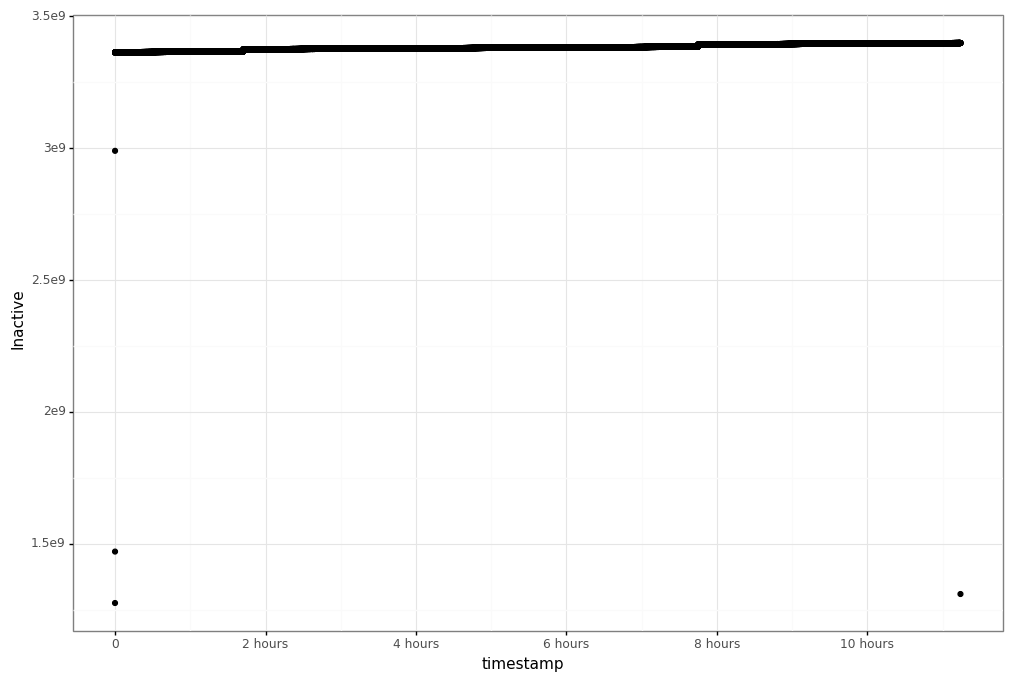

<ggplot: (8748932620015)>


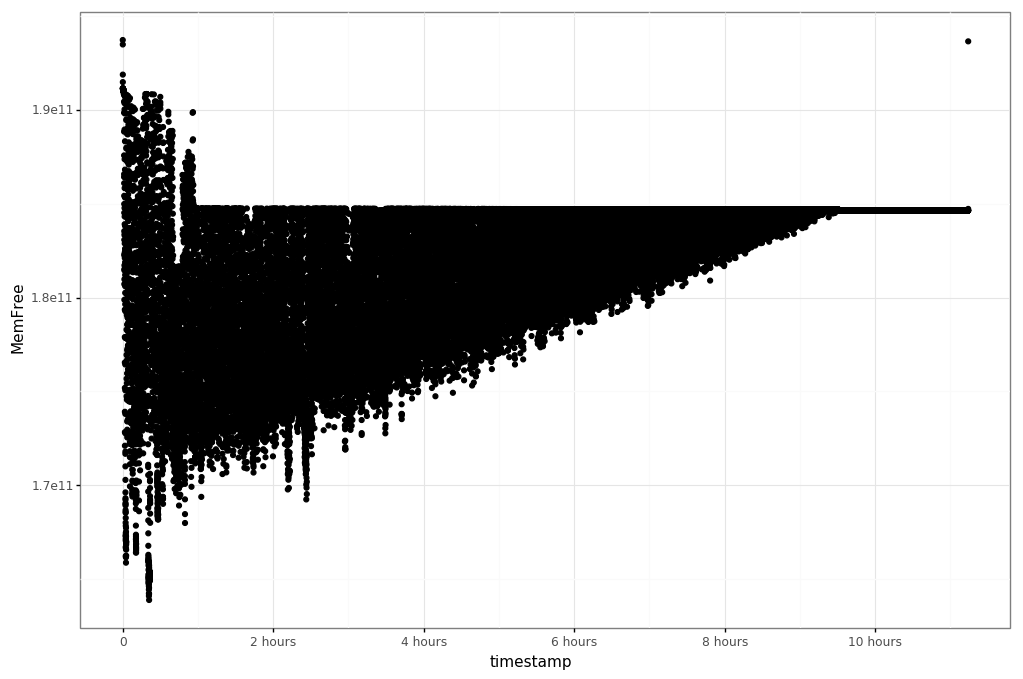

<ggplot: (-9223363287922203602)>


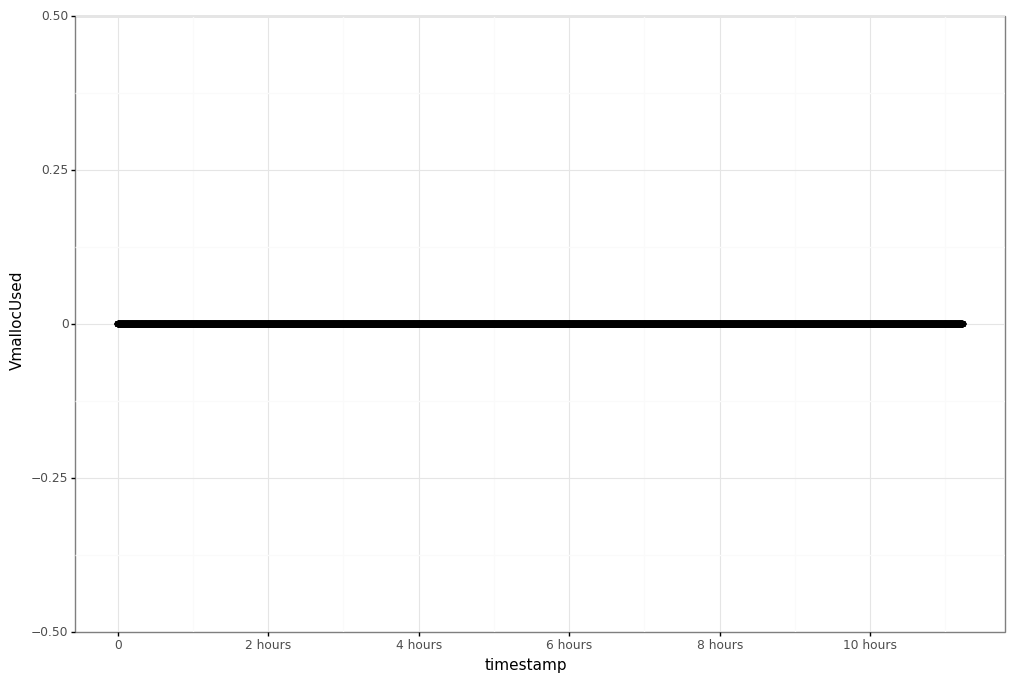

<ggplot: (8748932686684)>


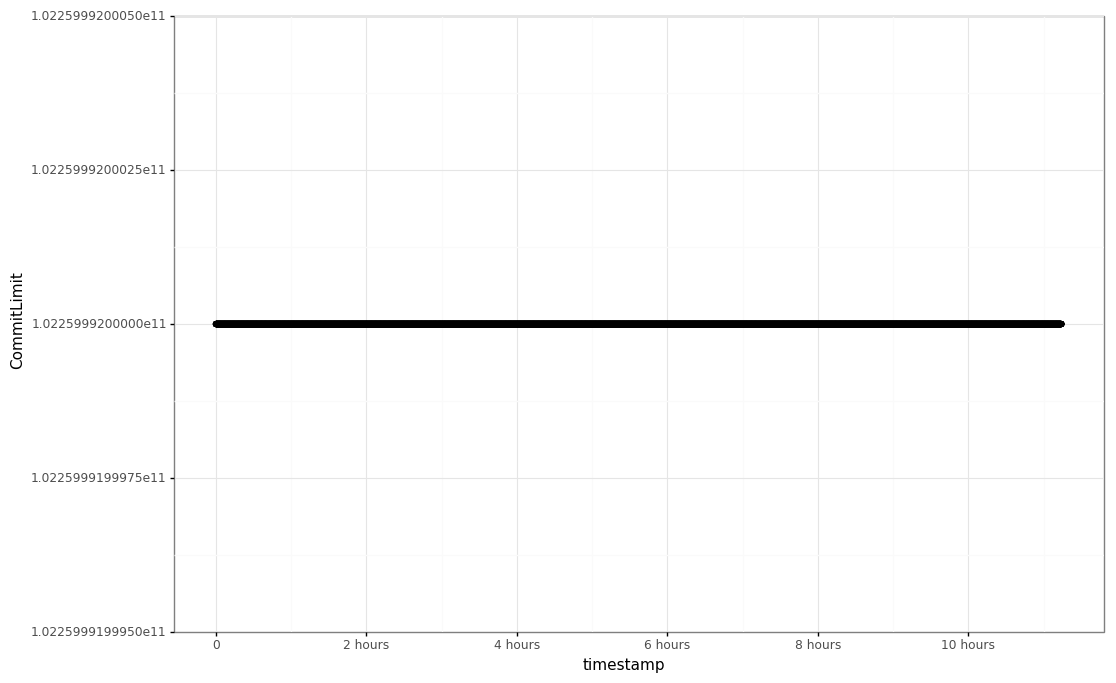

<ggplot: (-9223363287922074943)>


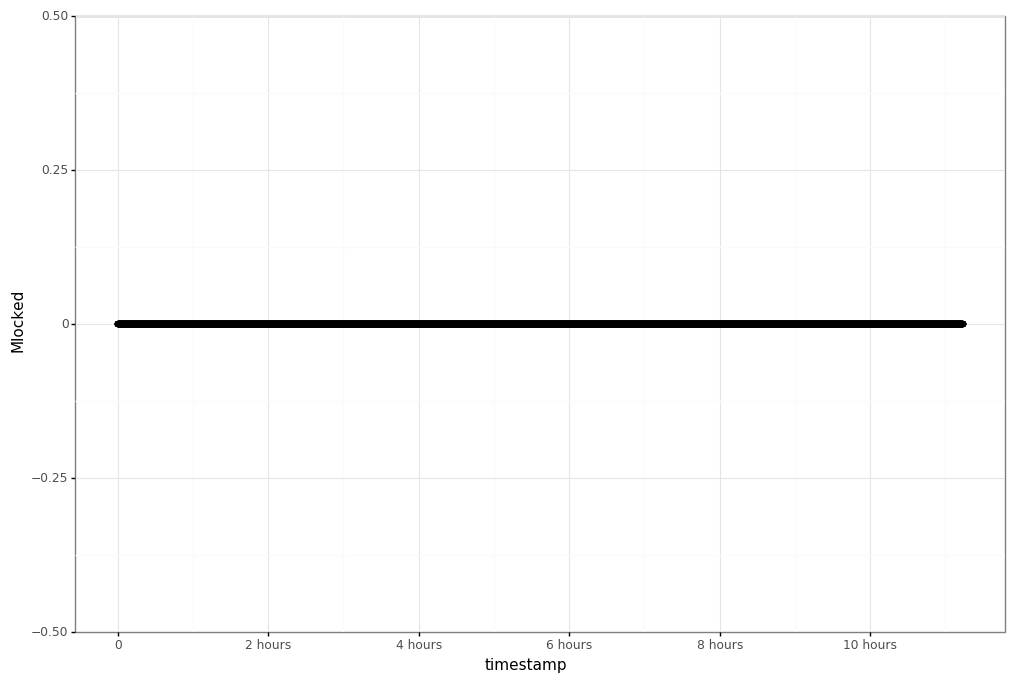

<ggplot: (8748894996039)>


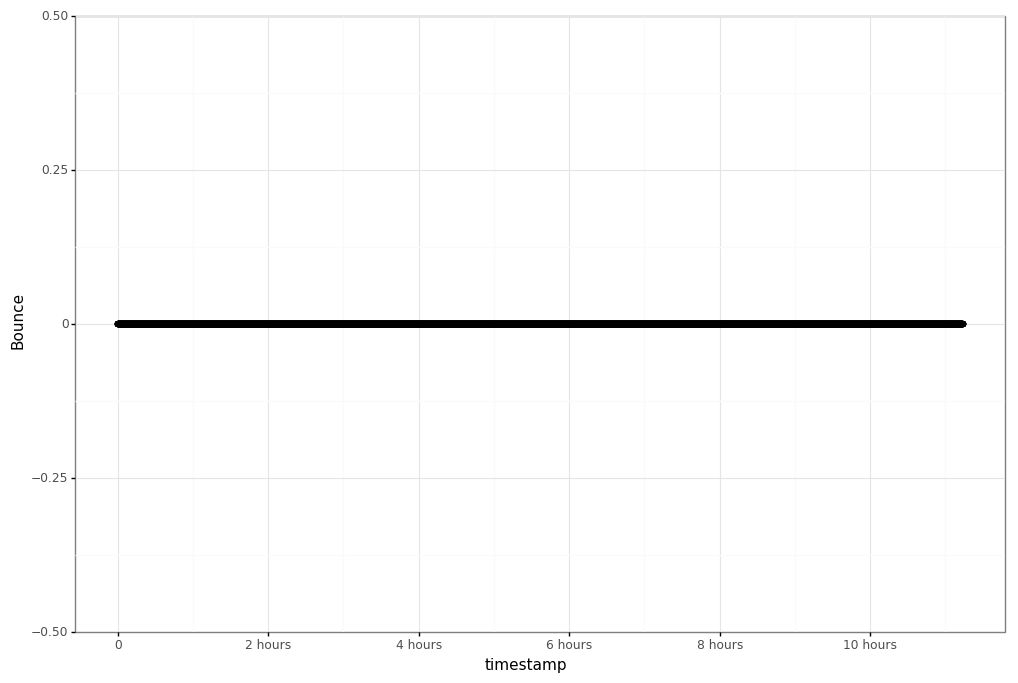

<ggplot: (8748932635042)>


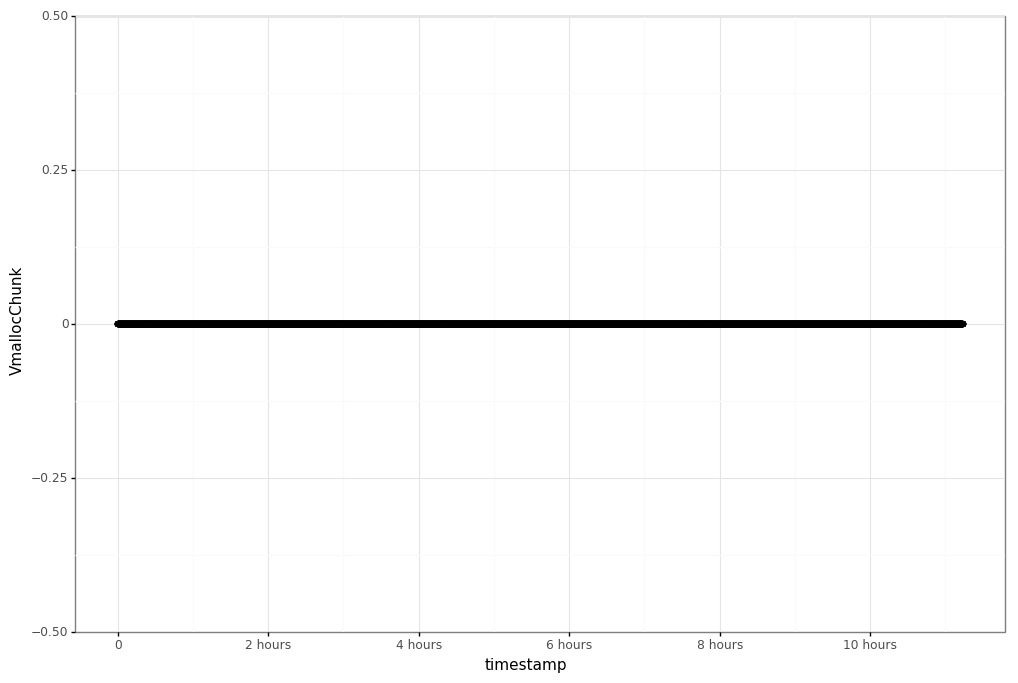

<ggplot: (-9223363287922098309)>


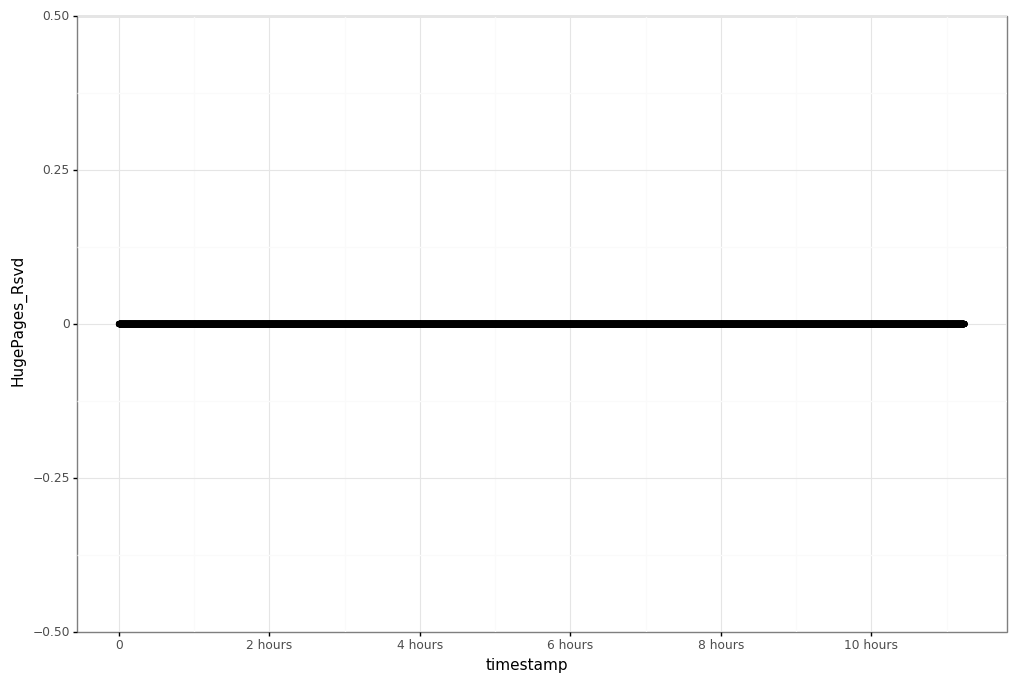

<ggplot: (8748896323080)>


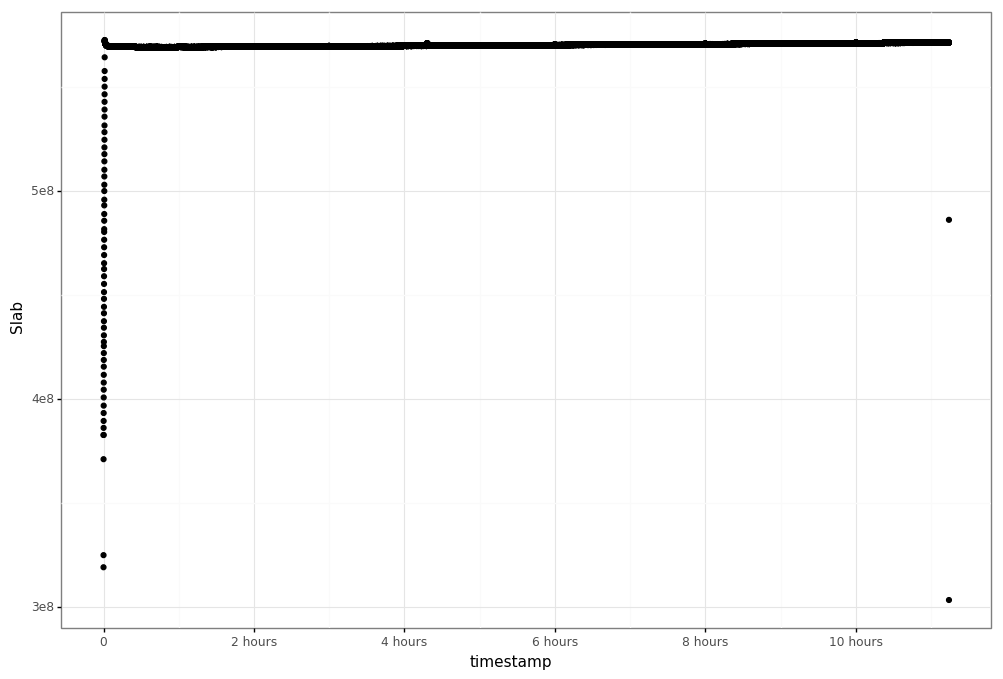

<ggplot: (8748932681434)>


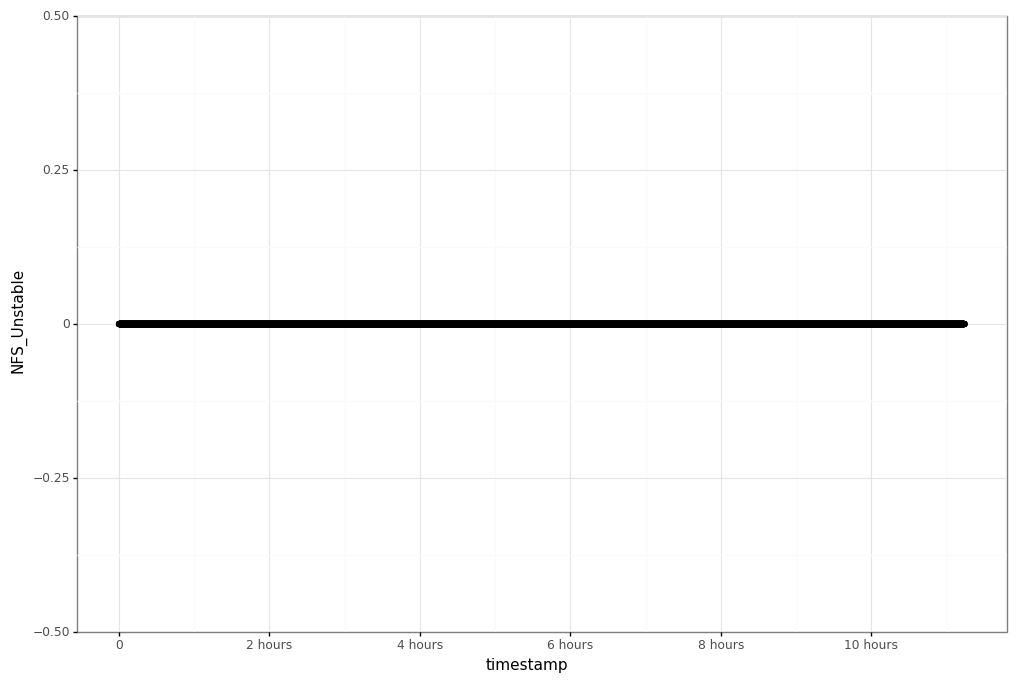

<ggplot: (8748932689549)>


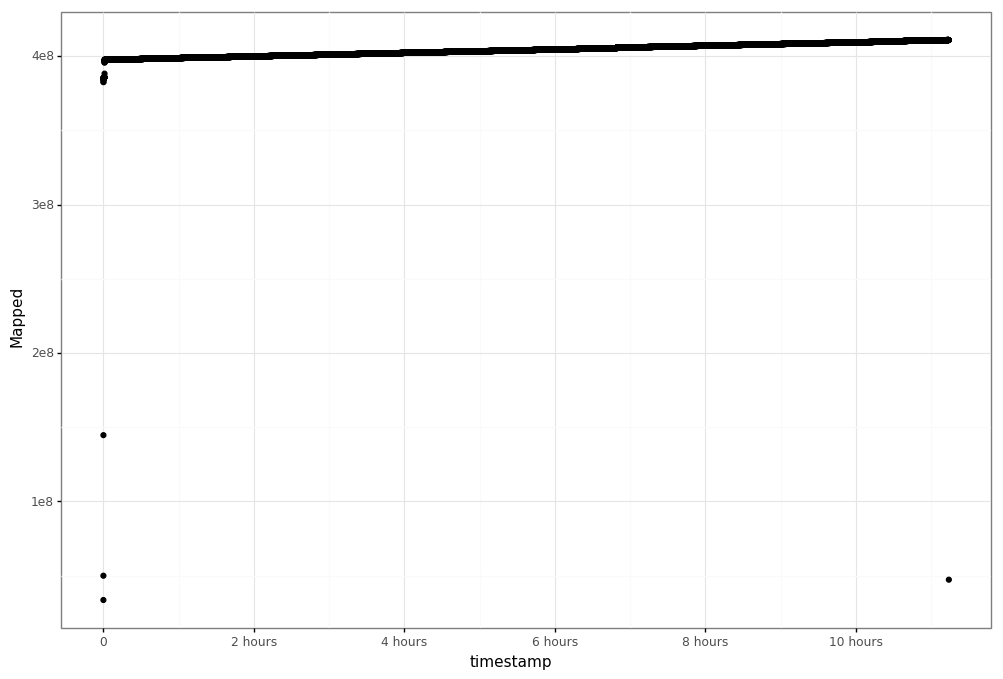

<ggplot: (8748932697180)>


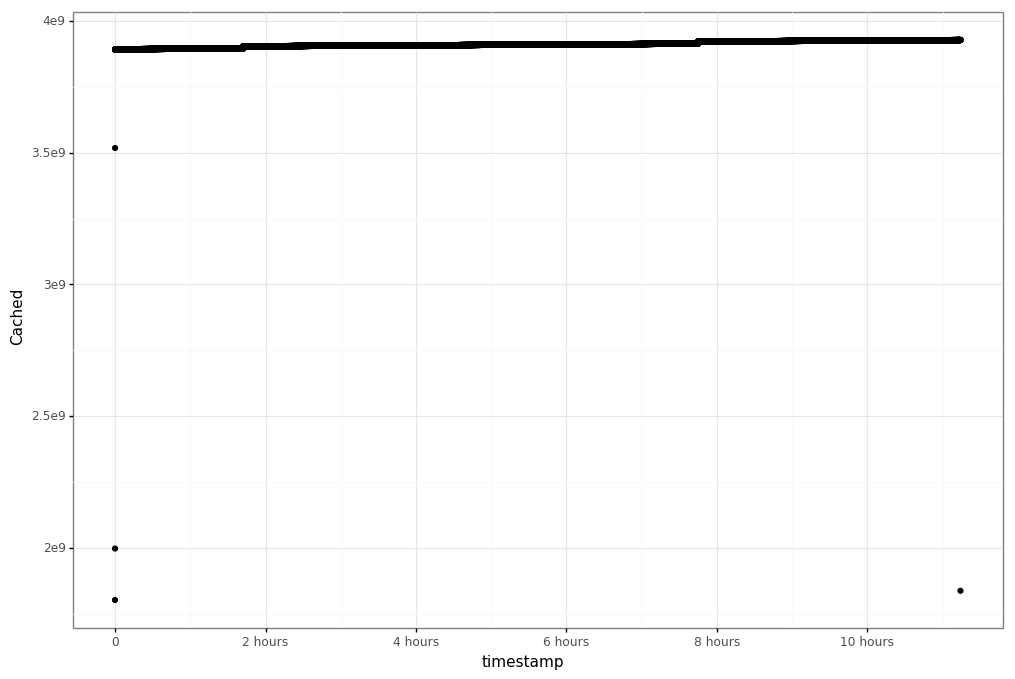

<ggplot: (-9223363287922155839)>


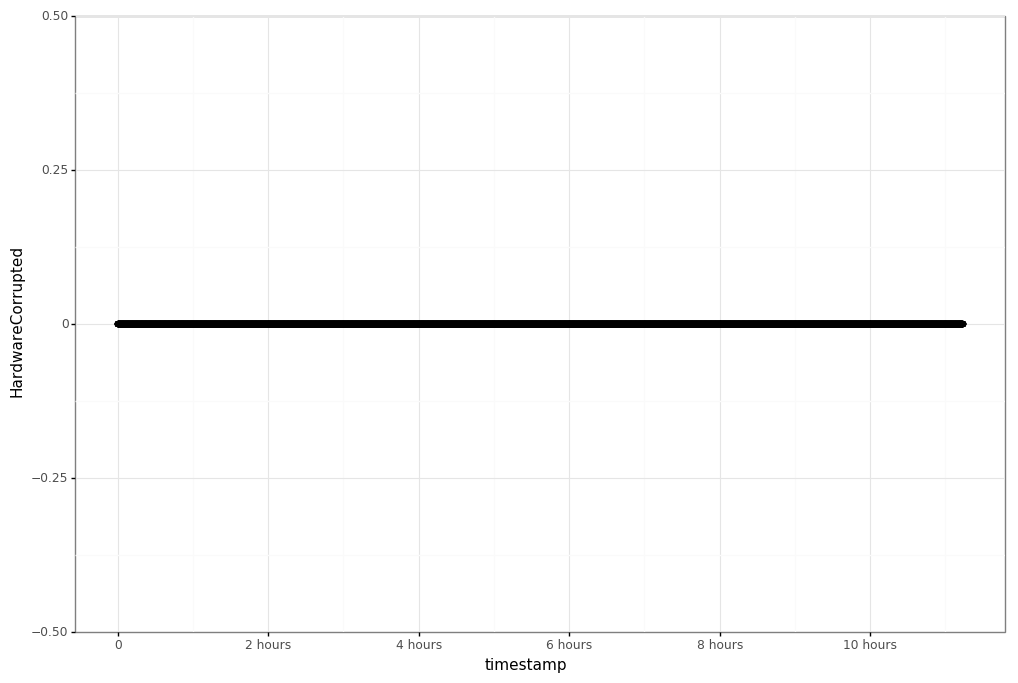

<ggplot: (-9223363287922064310)>


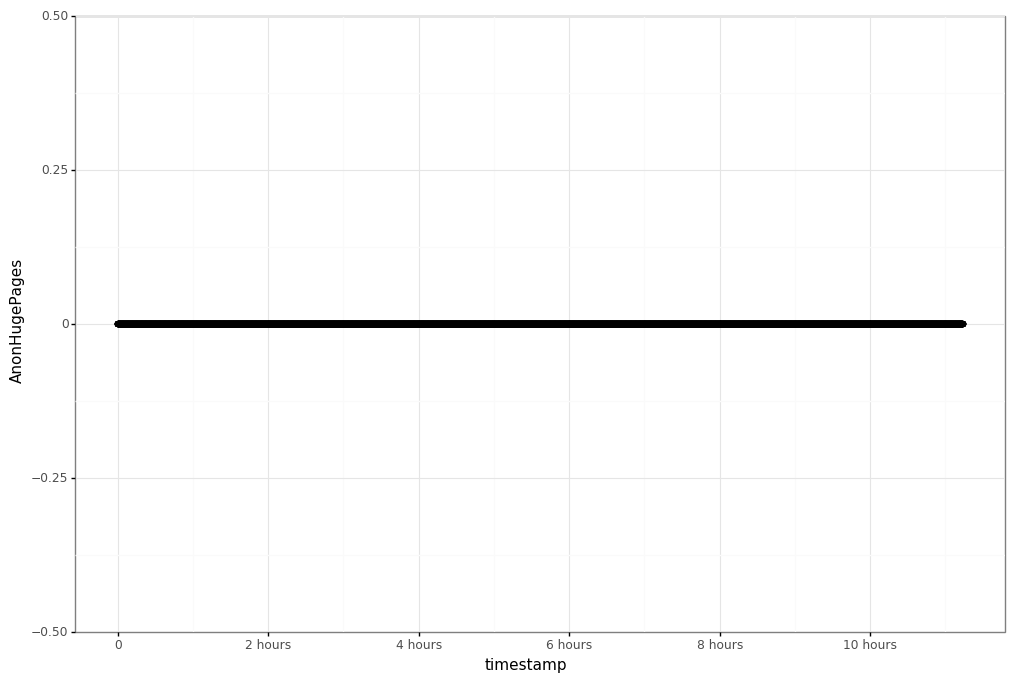

<ggplot: (8748885855194)>


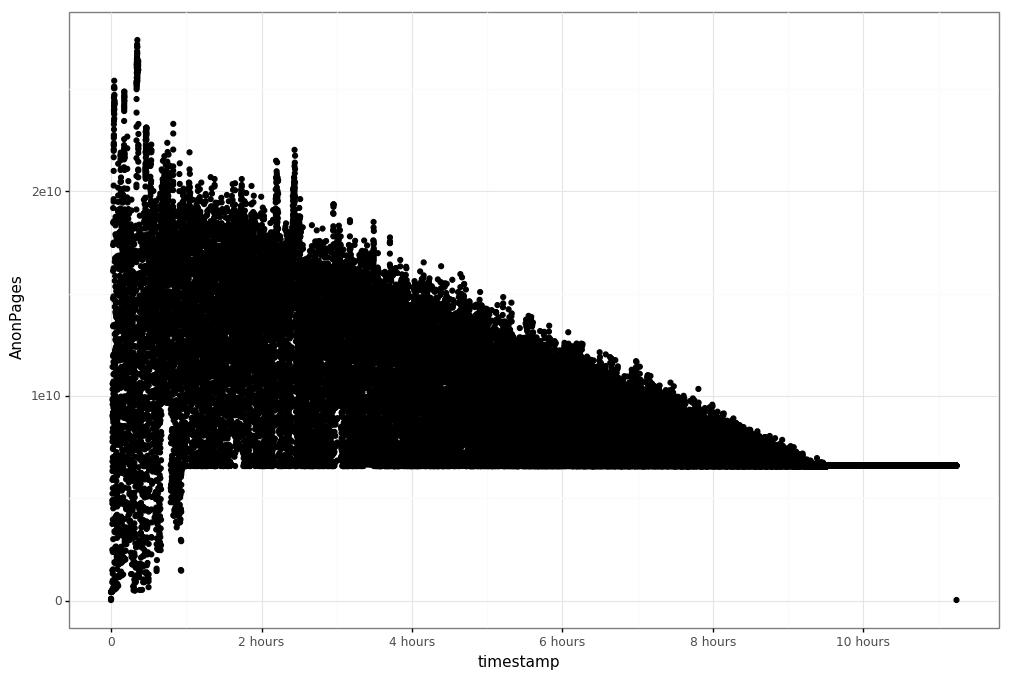

<ggplot: (-9223363287922098372)>


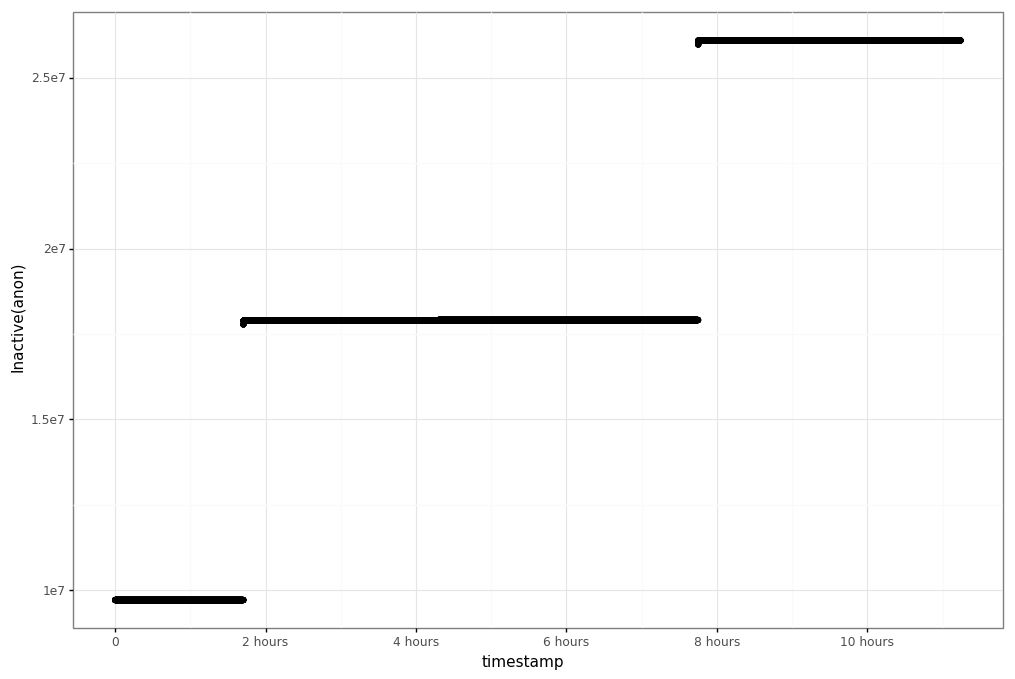

<ggplot: (8748932681343)>


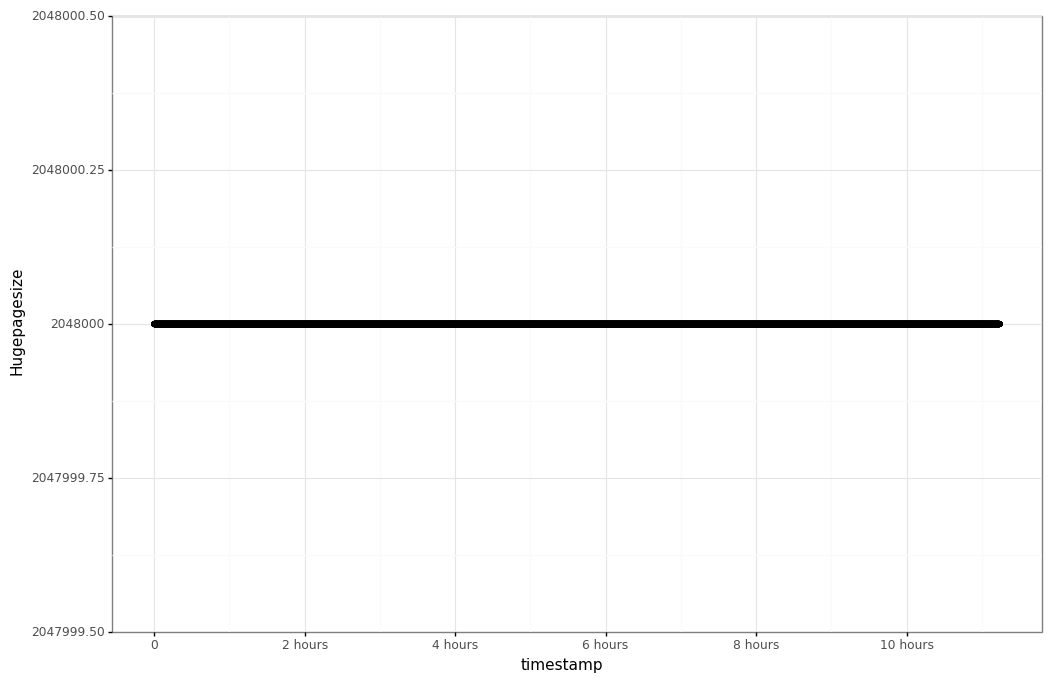

<ggplot: (8748932677440)>


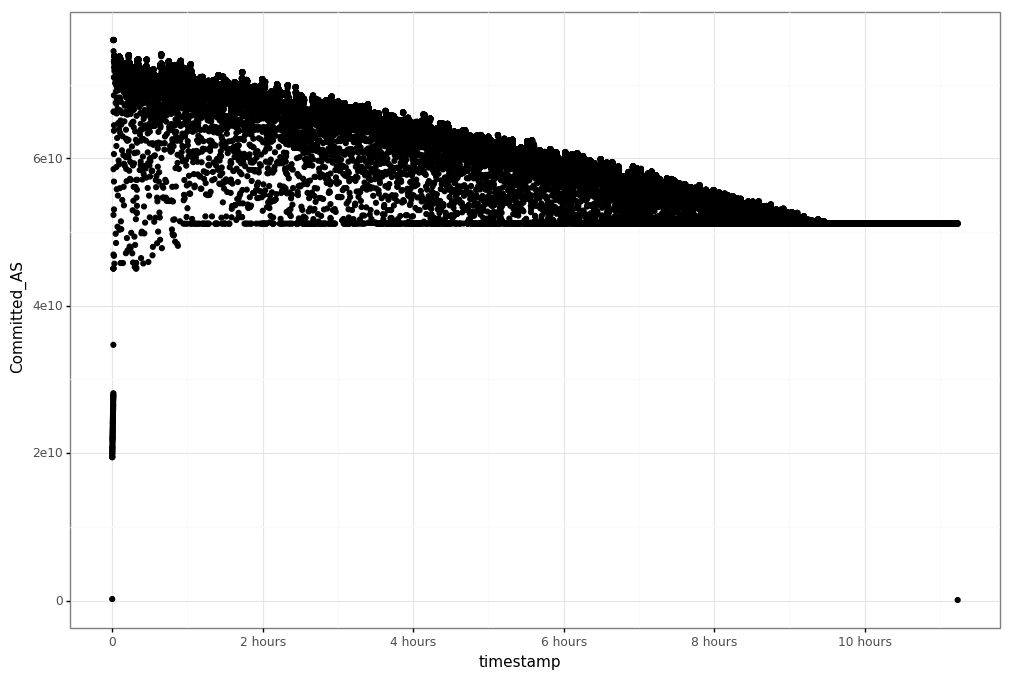

<ggplot: (8748958164004)>


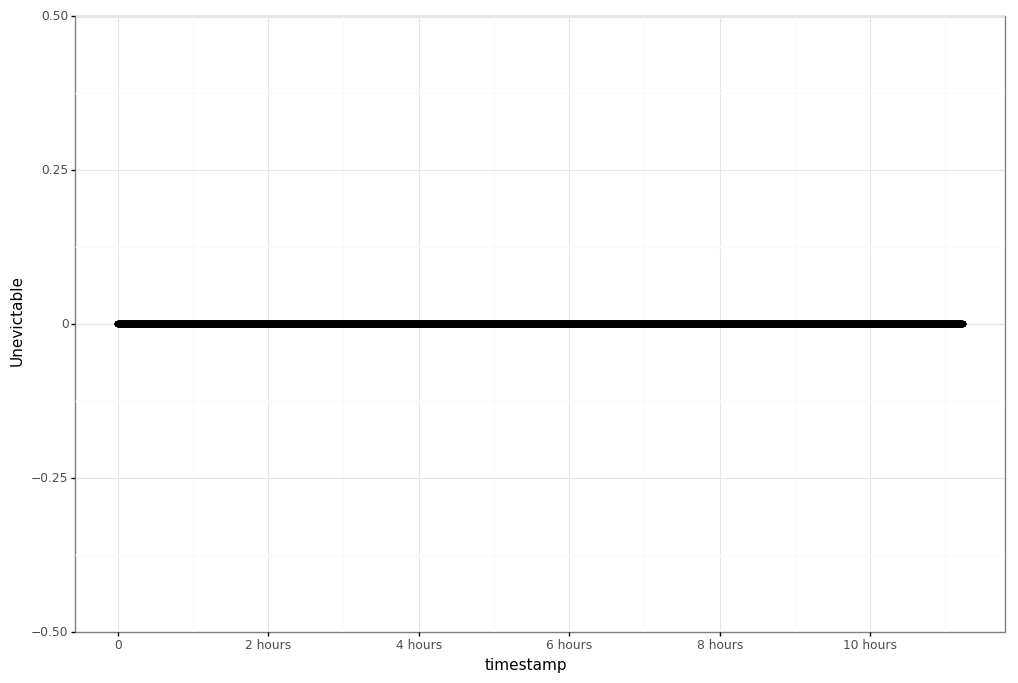

<ggplot: (8748932703976)>


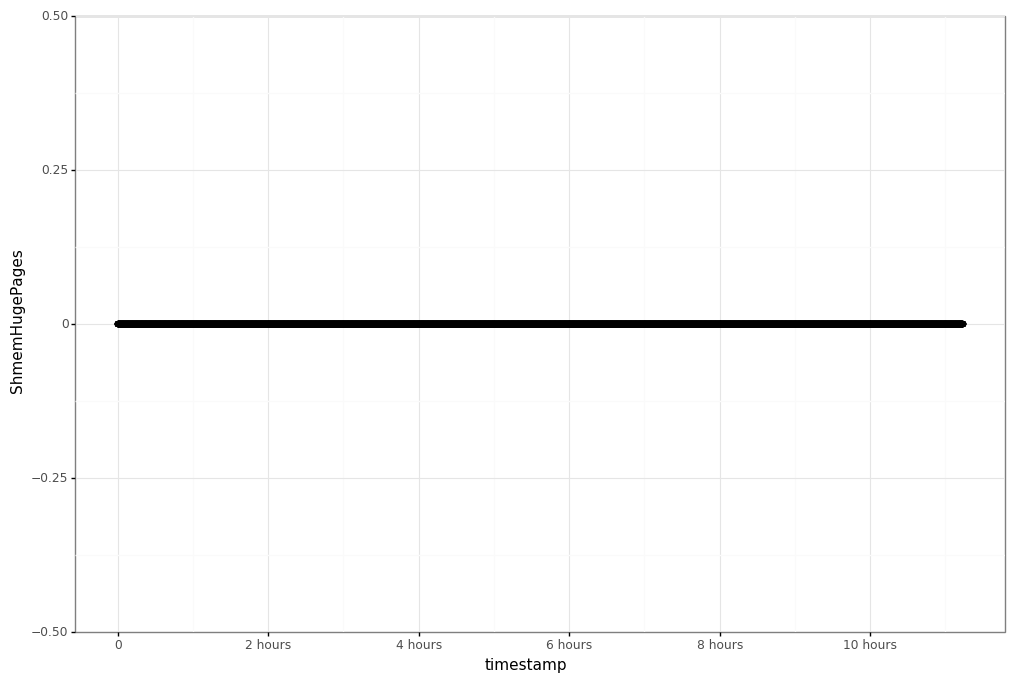

<ggplot: (8748932701255)>


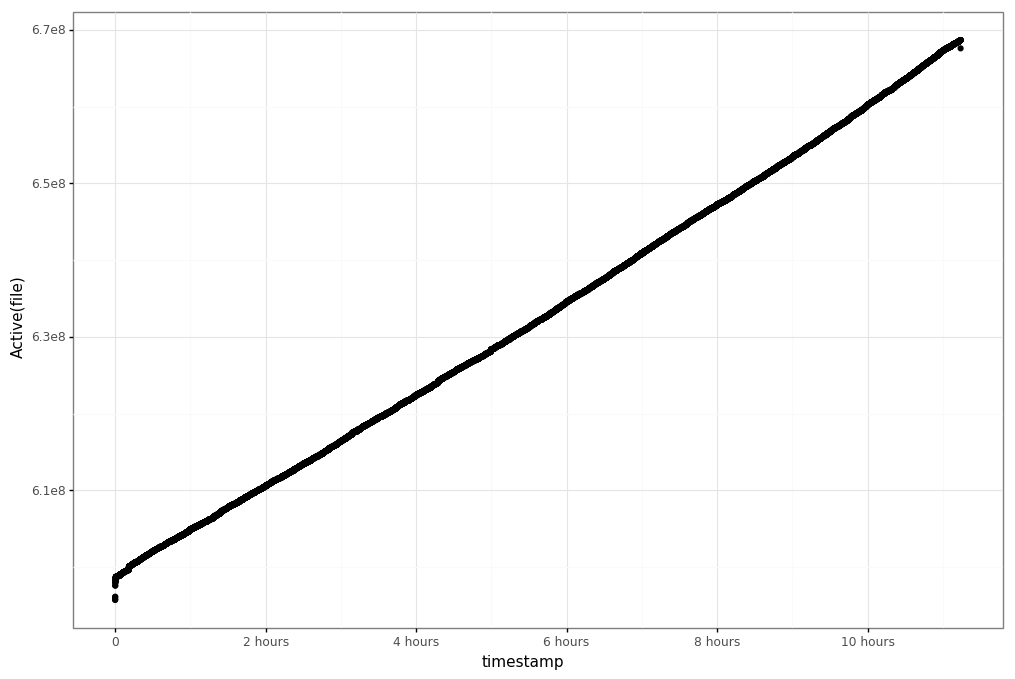

<ggplot: (8748932682942)>


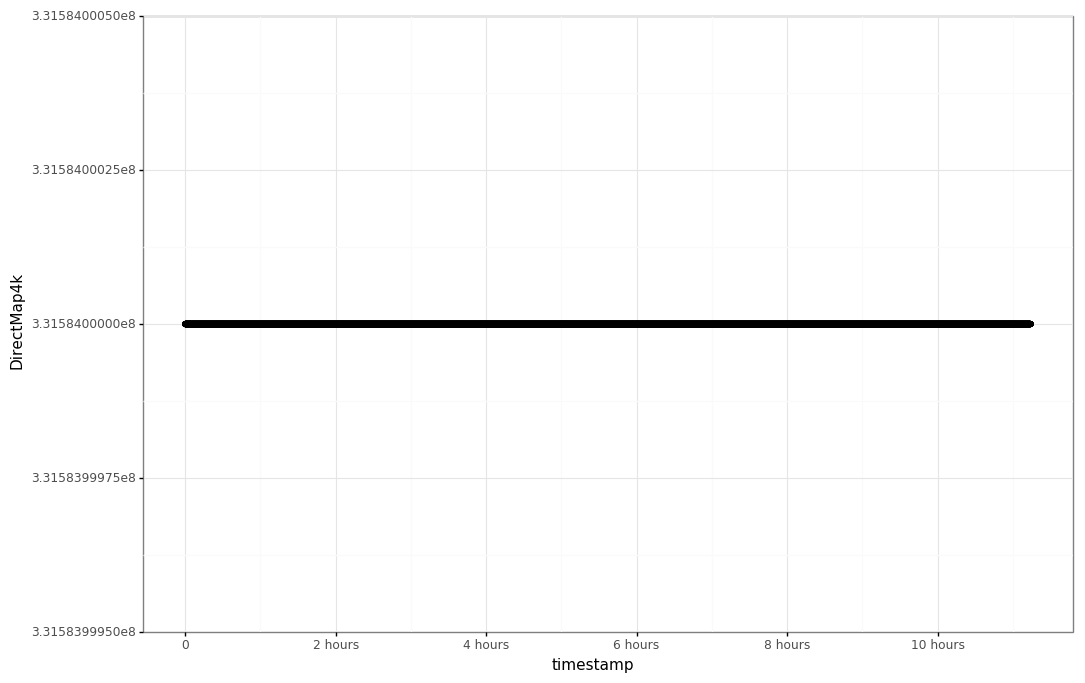

<ggplot: (-9223363287897157572)>


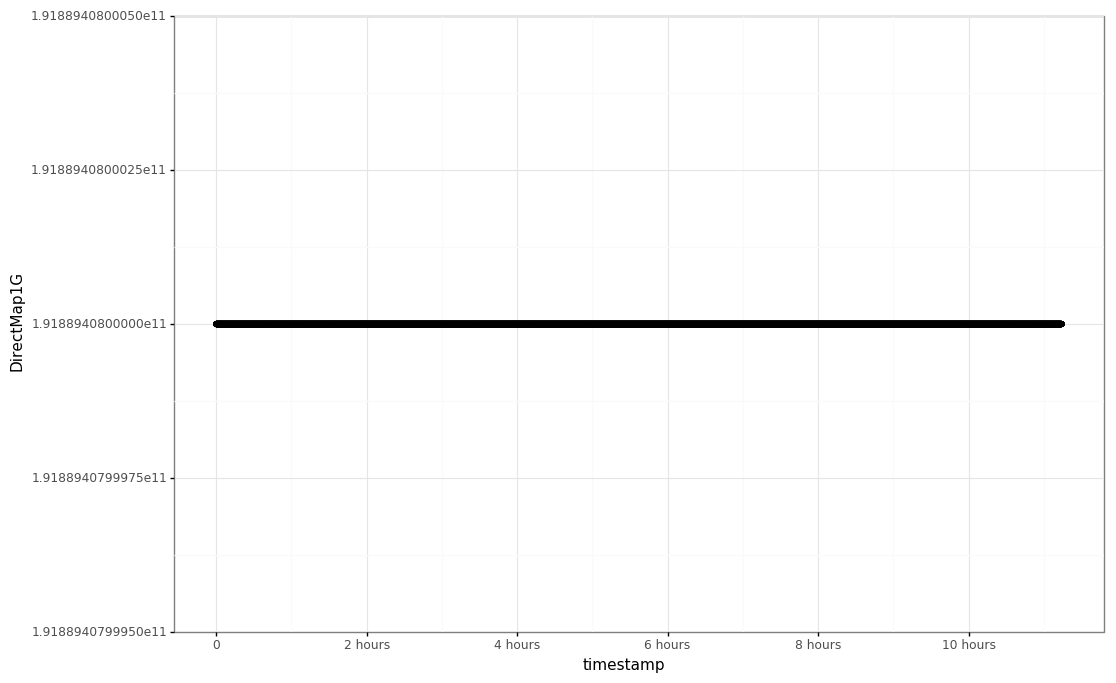

<ggplot: (8748932754850)>


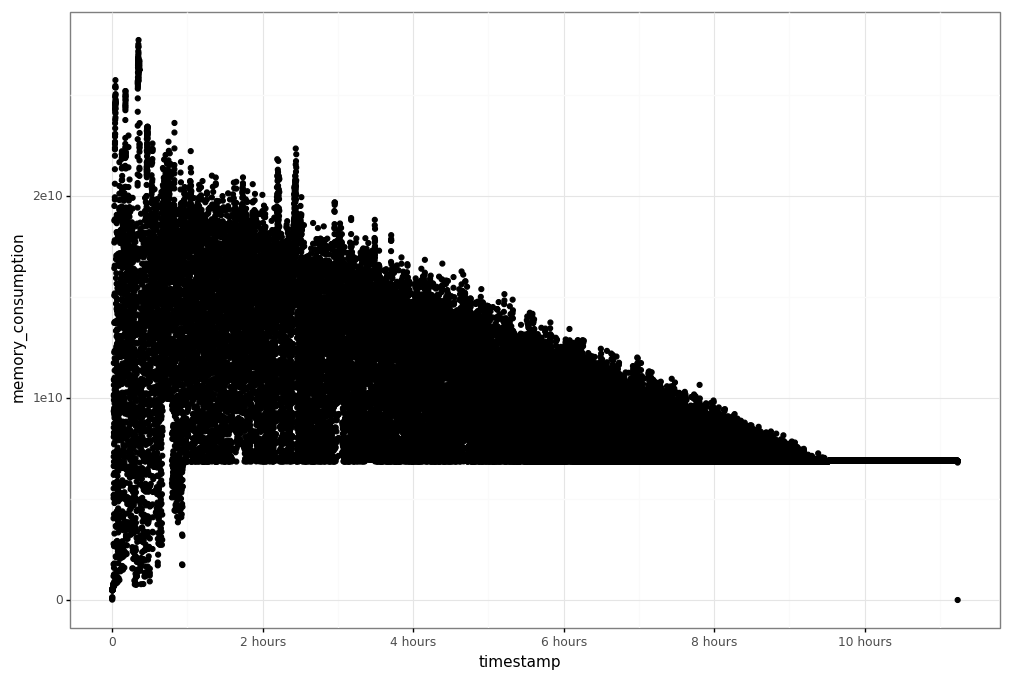

<ggplot: (8748895042603)>


In [10]:
for y in memory.columns:
    if y == 'timestamp':
        continue
    print(ggplot(memory, aes(x='timestamp', y=y)) + geom_point() + theme_bw())